##Task Statement

Predict whether a user will subscribe for more than 3 months based on users data and their activity in first 48 hours of subscription.

In [ ]:
!pip install scikit-optimize

In [ ]:
! pip install category_encoders

In [ ]:
! pip install hpsklearn

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from skopt import gp_minimize
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

Loading and Preprocessing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bad_users=pd.read_csv('/content/drive/MyDrive/scentbird data/ya_practicum_bad_users_info.csv')
good_users=pd.read_csv('/content/drive/MyDrive/scentbird data/ya_practicum_good_users_info.csv')

In [ ]:
bad_users.head()

,subscription_hash,channel,first_month_price,email_domain,first_payment_type,subscription_platform,signup_platform,fragrance_family,scent_profile_title,shipping_region,shipping_city,is_upgraded_in_first_2_days,is_upcharged_in_first_2_days,minutes_from_registration,subscription_lifetime,age_tier,sex,income_tier
0,6c6f36cd8eb42ef1d905578a6b0947f534d6132ae1c025...,Channel_3,3.00,0a208c9bd58a3c4a8afd770de83f090fdf74a53de73252...,Card,web,web,NaN,NaN,FL,SPRING HILL,False,False,3,2,45 to 54,female,25 to 49
1,73831634ef6d3639546fbb58f7ea4288220d907600fc9b...,Channel_1,11.21,86f85e9b7d3452597f1ac38acf948196a58ac22cdba276...,Card,web,web,NaN,NaN,PA,PHILADELPHIA,False,True,3,2,Below 18,male,50 to 74
2,75c705c4e9d81bb6037d2383118983f1f8009b6ae203d4...,Channel_1,11.21,b18226564f0740bc4e0785d34af8d56c85e278d32e321d...,NaN,web,web,NaN,NaN,IN,FRANKFORT,False,True,2,1,Below 18,female,25 to 49
3,20bb89aa63a1bc2a2f0c6e435a1da9057e52b6eec113fb...,Channel_3,3.00,86f85e9b7d3452597f1ac38acf948196a58ac22cdba276...,Card,web,web,NaN,NaN,TX,DENTON,False,False,3,1,Below 18,female,25 to 49
4,160647d08b5d29ad4039b58f0c8f6515c29cdc7aae517e...,Channel_1,11.21,86f85e9b7d3452597f1ac38acf948196a58ac22cdba276...,NaN,web,web,NaN,NaN,TX,CONROE,True,False,2,2,Below 18,female,25 to 49


In [ ]:
bad_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134177 entries, 0 to 134176
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   subscription_hash             134177 non-null  object 
 1   channel                       134177 non-null  object 
 2   first_month_price             134177 non-null  float64
 3   email_domain                  134177 non-null  object 
 4   first_payment_type            106437 non-null  object 
 5   subscription_platform         134177 non-null  object 
 6   signup_platform               116570 non-null  object 
 7   fragrance_family              4665 non-null    object 
 8   scent_profile_title           4665 non-null    object 
 9   shipping_region               134177 non-null  object 
 10  shipping_city                 134177 non-null  object 
 11  is_upgraded_in_first_2_days   134177 non-null  bool   
 12  is_upcharged_in_first_2_days  134177 non-nul

In [ ]:
len(bad_users['subscription_hash'].unique())                   #subscription hash contains duplicate values

133153


<font color='green'> 
**FM comments:**

Usefull finding! Well done!

</font>

In [ ]:
bad_users['subscription_hash'].value_counts()

9ab342133acfaa3b108b5455004907c8377789cb7c864d9419b33eeb0dddf96f    4
e3f3a92cf5b68dfebae7650a7f3d16f6e55b9b11a027f93aec192bae921c3613    4
4b0ecfd184c8bd3546cd00ad6c52b28ab20ea1165d10f992037502d86df968f1    4
0cf7646363e631866727f0fd85d48d1d03b22115c611be4ed3aa7d350b251f74    4
8d0a266053a39d06ff5c33614ae39adeab9a70a5c6b38b4389971cad6f30ac80    4
                                                                   ..
2ce764ce26ef562780cf148f75dcb6099d1621172aa8c2b17738d274b60a91d6    1
614e4cda2461bed725bbdc82041e381893604a362f9f41add6a2916b52ff75fe    1
70be8b4543bf8781f2842ff5869106954e0a309af91d06d1245eb28504c55450    1
af1e59762b1d7a9f2d83078c56ff9fec7785a8f51d6c34cb93c1eb462d02b2c5    1
7987ab329a37ea70cbd53804ddf1d42cdb9f69c36373ba3485517f2c88f51b11    1
Name: subscription_hash, Length: 133153, dtype: int64

In [ ]:
bad_users[bad_users['subscription_hash']=='e703b7bc90e51770454598cdb2c32c27c7b7dd520bde2d24ff90d190ff03f01d']

,subscription_hash,channel,first_month_price,email_domain,first_payment_type,subscription_platform,signup_platform,fragrance_family,scent_profile_title,shipping_region,shipping_city,is_upgraded_in_first_2_days,is_upcharged_in_first_2_days,minutes_from_registration,subscription_lifetime,age_tier,sex,income_tier
39591,e703b7bc90e51770454598cdb2c32c27c7b7dd520bde2d...,Channel_1,11.21,86f85e9b7d3452597f1ac38acf948196a58ac22cdba276...,Card,web,web,NaN,NaN,IN,INDIANAPOLIS,False,True,2,2,Below 18,female,25 to 49
40458,e703b7bc90e51770454598cdb2c32c27c7b7dd520bde2d...,Channel_1,11.21,86f85e9b7d3452597f1ac38acf948196a58ac22cdba276...,Card,web,web,NaN,NaN,IN,INDIANAPOLIS,True,True,2,2,Below 18,female,25 to 49
40649,e703b7bc90e51770454598cdb2c32c27c7b7dd520bde2d...,Channel_1,11.21,86f85e9b7d3452597f1ac38acf948196a58ac22cdba276...,Card,web,web,NaN,NaN,IN,INDIANAPOLIS,False,False,2,2,Below 18,female,25 to 49
44626,e703b7bc90e51770454598cdb2c32c27c7b7dd520bde2d...,Channel_1,11.21,86f85e9b7d3452597f1ac38acf948196a58ac22cdba276...,Card,web,web,NaN,NaN,IN,INDIANAPOLIS,True,False,2,2,Below 18,female,25 to 49


In [ ]:
bad_users.drop_duplicates(subset='subscription_hash',ignore_index=True,inplace=True)

In [ ]:
bad_users['fragrance_family'].fillna(0,inplace=True)                        #encoding fragrance family in 0,1
bad_users.loc[bad_users['fragrance_family']!=0,'fragrance_family']=1         #any value will be 1 and missing value will be 0
bad_users['fragrance_family'].value_counts()

0    128658
1      4495
Name: fragrance_family, dtype: int64

In [ ]:
bad_users['channel'].value_counts()

Channel_3    95636
Channel_1    29595
Channel_2     7922
Name: channel, dtype: int64

In [ ]:
bad_users['first_month_price'].value_counts()                         #It's a categorical column!

3.00     95636
11.21    37517
Name: first_month_price, dtype: int64

In [ ]:
bad_users.groupby(['first_month_price','channel'])['channel'].count()

first_month_price  channel  
3.00               Channel_3    95636
11.21              Channel_1    29595
                   Channel_2     7922
Name: channel, dtype: int64

We can see that all customers coming through channel 3 pay 3 dollars and none from channel 3 buy the 11.21 dollar subscription

In [ ]:
bad_users.groupby('channel')['first_month_price'].sum()

channel
Channel_1    331759.95
Channel_2     88805.62
Channel_3    286908.00
Name: first_month_price, dtype: float64

Even though channel 1 brings almost 3 times less customers, it generates more revenue than channel 3.

In [ ]:
bad_users['first_payment_type'].value_counts()/len(bad_users)

Card            0.584433
PayPal          0.202324
Prepaid Card    0.007097
Name: first_payment_type, dtype: float64

In [ ]:
#bad_users['first_payment_type'].fillna('Card',inplace=True)

In [ ]:
bad_users['signup_platform'].value_counts()/len(bad_users)

web        0.868647
iOS        0.000150
Android    0.000135
Name: signup_platform, dtype: float64

The number of customers in iOS and android category is highly insignificant. 

In [ ]:
bad_users['shipping_region'].value_counts().reset_index()

,index,shipping_region
0,CA,13778
1,TX,13514
2,FL,9586
3,NY,7878
4,GA,5694
5,OH,4713
6,NC,4600
7,PA,4597
8,IL,4506
9,MI,3675


In [ ]:
good_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134177 entries, 0 to 134176
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   subscription_hash             134177 non-null  object 
 1   channel                       134177 non-null  object 
 2   first_month_price             134177 non-null  float64
 3   email_domain                  134177 non-null  object 
 4   first_payment_type            67889 non-null   object 
 5   subscription_platform         134177 non-null  object 
 6   signup_platform               124801 non-null  object 
 7   fragrance_family              17952 non-null   object 
 8   scent_profile_title           17952 non-null   object 
 9   shipping_region               134177 non-null  object 
 10  shipping_city                 134177 non-null  object 
 11  is_upgraded_in_first_2_days   134177 non-null  bool   
 12  is_upcharged_in_first_2_days  134177 non-nul

In [ ]:
good_users['subscription_hash'].value_counts()                      #checking for duplicates in subscription hash

0e651d1e26378116bf5ae716b1cad848d77c07dc0f6d6fc0cc47e68e5622d647    4
52f2321c8f6a4a1aadc9fd1c483e7a805f9da08569b352616cc34c8d84c7711f    4
53095d2ead74945eb1279f9727e161f1d1b61c4fab4d0ee2d7784926e3b5ff9d    4
cacd7e6739e9e2a58e7a10976829e31a2d349deac6a42d028cd9a4787b397b8a    4
9c92b64b3261579e3c97ed14eb10d0f4f006c721e0e434804c393d6e920ec2bc    4
                                                                   ..
bd21b67bd233e1e0770c0f0d16716ef446ff72f062e237ebcb3a85d3ac23d454    1
ebbb8840a118a23f6a408c5f33a4575d1b9b4e5e6944b9bb6e041abbb5e392c5    1
102f4e5cc91ede104b5074f678df1b614976693397d5ec21bbf2b00daa139476    1
65c82b88cae8bf52a4689a27d6bc533df66afea31ce45f72667016669919deb8    1
d4f0957f5593dda661239d2fd45260eedb4632c68686777a0e9cac09f5048c40    1
Name: subscription_hash, Length: 131115, dtype: int64

In [ ]:
good_users[good_users['subscription_hash']=='0e651d1e26378116bf5ae716b1cad848d77c07dc0f6d6fc0cc47e68e5622d647']

,subscription_hash,channel,first_month_price,email_domain,first_payment_type,subscription_platform,signup_platform,fragrance_family,scent_profile_title,shipping_region,shipping_city,is_upgraded_in_first_2_days,is_upcharged_in_first_2_days,minutes_from_registration,subscription_lifetime,age_tier,sex,income_tier
43135,0e651d1e26378116bf5ae716b1cad848d77c07dc0f6d6f...,Channel_3,3.0,b18226564f0740bc4e0785d34af8d56c85e278d32e321d...,Card,web,NaN,NaN,NaN,OR,PORTLAND,True,True,2364095,5,Below 18,female,25 to 49
54633,0e651d1e26378116bf5ae716b1cad848d77c07dc0f6d6f...,Channel_3,3.0,b18226564f0740bc4e0785d34af8d56c85e278d32e321d...,Card,web,NaN,NaN,NaN,OR,PORTLAND,False,True,2364095,5,Below 18,female,25 to 49
55259,0e651d1e26378116bf5ae716b1cad848d77c07dc0f6d6f...,Channel_3,3.0,b18226564f0740bc4e0785d34af8d56c85e278d32e321d...,Card,web,NaN,NaN,NaN,OR,PORTLAND,True,False,2364095,5,Below 18,female,25 to 49
118438,0e651d1e26378116bf5ae716b1cad848d77c07dc0f6d6f...,Channel_3,3.0,b18226564f0740bc4e0785d34af8d56c85e278d32e321d...,Card,web,NaN,NaN,NaN,OR,PORTLAND,False,False,2364095,5,Below 18,female,25 to 49


In [ ]:
good_users.drop_duplicates(subset='subscription_hash',ignore_index=True,inplace=True)
#good_users.info()

In [ ]:
good_users['fragrance_family'].fillna(0,inplace=True)
good_users.loc[good_users['fragrance_family']!=0,'fragrance_family']=1
good_users['fragrance_family'].value_counts()

0    114522
1     16593
Name: fragrance_family, dtype: int64

In [ ]:
good_users['first_payment_type'].value_counts()/len(good_users)

Card            0.405728
PayPal          0.090035
Prepaid Card    0.014705
Name: first_payment_type, dtype: float64

In [ ]:
good_users['signup_platform'].value_counts()/len(good_users)

web        0.929650
Android    0.000236
iOS        0.000206
Name: signup_platform, dtype: float64

For good users also the signup platform is highly dominated by web only 

In [ ]:
good_users['channel'].value_counts()/len(good_users)

Channel_3    0.723441
Channel_1    0.219372
Channel_2    0.057186
Name: channel, dtype: float64

In [ ]:
good_users.groupby(['first_month_price','channel'])['channel'].count()

first_month_price  channel  
3.00               Channel_3    94854
11.21              Channel_1    28763
                   Channel_2     7498
Name: channel, dtype: int64

Exactly what we obsersved for bad_users. Users coming through channel_3 only pay 3.00 and none from channel_1 and channel_2 pay 3 dollars. Channels are probably marketing channels where channel_3 is the cheaper channel.


<font color='green'> 
**FM comments:**

Nice!
</font>

Exploratory Data Analysis

Text(0.5, 1.0, 'Income tier distribution for bad and good users')

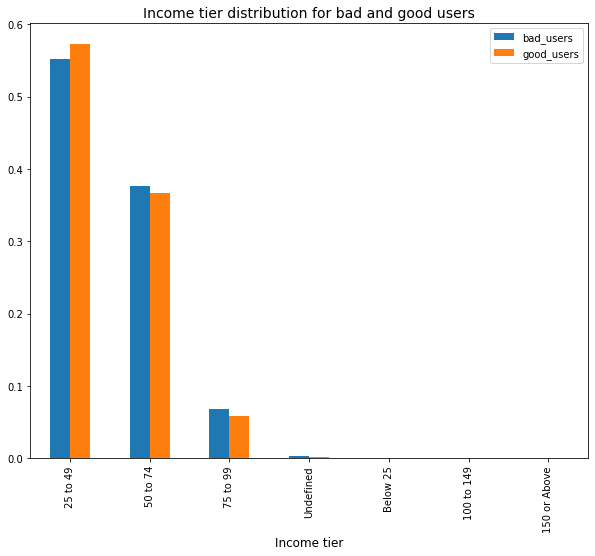

In [ ]:
bad=bad_users['income_tier'].value_counts()/len(bad_users)
good=good_users['income_tier'].value_counts()/len(good_users)
df=pd.concat([bad,good],axis=1).reset_index()
df.columns=['index','bad_users','good_users']
df.plot.bar(x='index',figsize=(10,8))
#plt.legend(['bad users','good_users'])
plt.xlabel('Income tier',fontsize=12)
plt.title('Income tier distribution for bad and good users', fontsize=14)
#sns.barplot(bad_income,x=bad_income.index,y='income_tier')

Income tier distribution for bad and good users is quite similar

Text(0.5, 1.0, 'Age tier distribution for bad and good users')

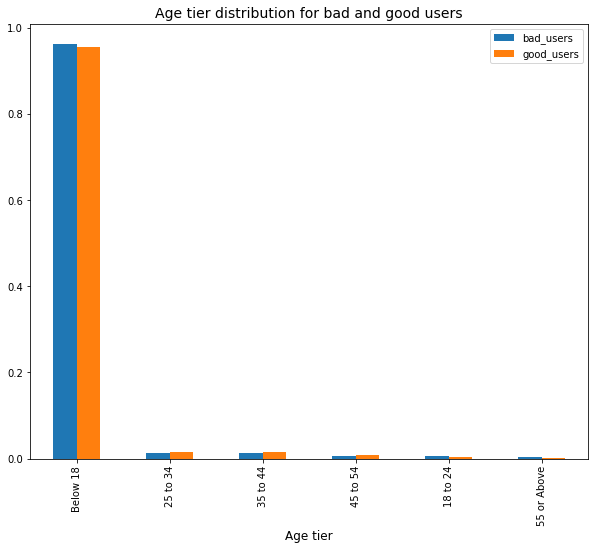

In [ ]:
bad=bad_users['age_tier'].value_counts()/len(bad_users)
good=good_users['age_tier'].value_counts()/len(good_users)
df=pd.concat([bad,good],axis=1).reset_index()
df.columns=['index','bad_users','good_users']
df.plot.bar(x='index',figsize=(10,8))
#plt.legend(['bad users','good_users'])
plt.xlabel('Age tier',fontsize=12)
plt.title('Age tier distribution for bad and good users', fontsize=14)
#sns.barplot(bad_income,x=bad_income.index,y='income_tier')

Age distribution for bad and good users is also very similar.

In [ ]:
bad_users['sex'].value_counts()/len(bad_users)

female    0.792517
male      0.207483
Name: sex, dtype: float64

In [ ]:
good_users['sex'].value_counts()/len(good_users)

female    0.766838
male      0.233162
Name: sex, dtype: float64

Text(0.5, 1.0, 'Top 10 shipping regions for both bad and good users')

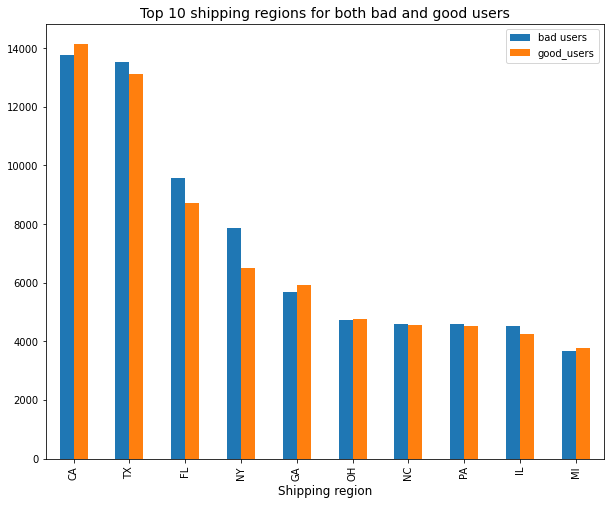

In [ ]:
bad=bad_users['shipping_region'].value_counts().head(10)
good=good_users['shipping_region'].value_counts().head(10)
df=pd.concat([bad,good],axis=1).reset_index()
df.plot.bar(x='index',figsize=(10,8))
plt.legend(['bad users','good_users'])
plt.xlabel('Shipping region',fontsize=12)
plt.title('Top 10 shipping regions for both bad and good users', fontsize=14)

In [ ]:
region=list(good_users['shipping_region'].value_counts().index[0:5])

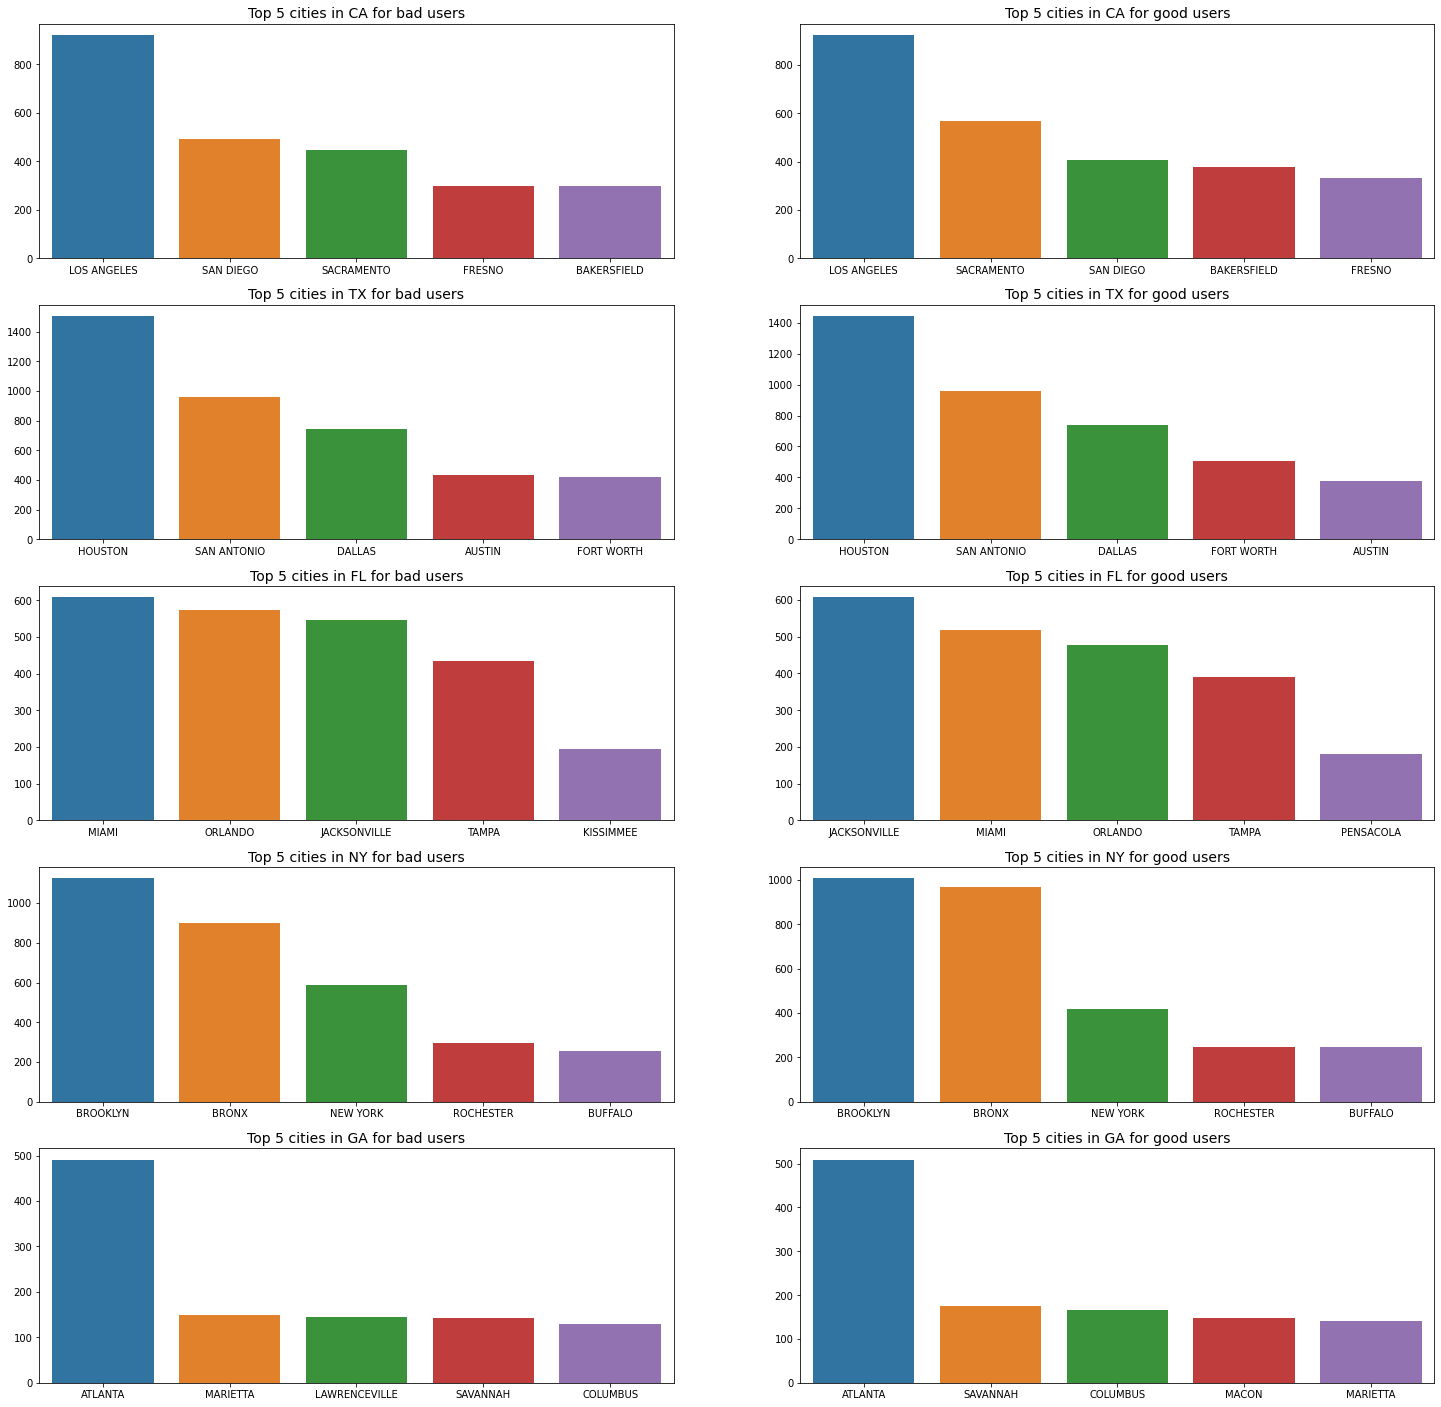

In [ ]:
f,ax=plt.subplots(nrows=5,ncols=2,figsize=(25,25))

for i,reg in enumerate(region):
  bad_reg=bad_users[bad_users.loc[:,'shipping_region']==reg].groupby('shipping_city')['shipping_city'].count().sort_values(ascending=False).head(5)
  good_reg=good_users[good_users.loc[:,'shipping_region']==reg].groupby('shipping_city')['shipping_city'].count().sort_values(ascending=False).head(5)
  #print(bad_reg.values)
  sns.barplot(x=list(bad_reg.index),y=bad_reg.values,ax=ax[i,0])
  sns.barplot(x=list(good_reg.index),y=good_reg.values,ax=ax[i,1])
  ax[i,0].set_title('Top 5 cities in {} for bad users'.format(reg),fontsize=14)
  ax[i,1].set_title('Top 5 cities in {} for good users'.format(reg),fontsize=14)

We can see a difference between good users and bad users at city level meaning all features we have seen so fas have very similar distribution for both users but cities in top 5 regions shows some degree of difference although it is not very significant 

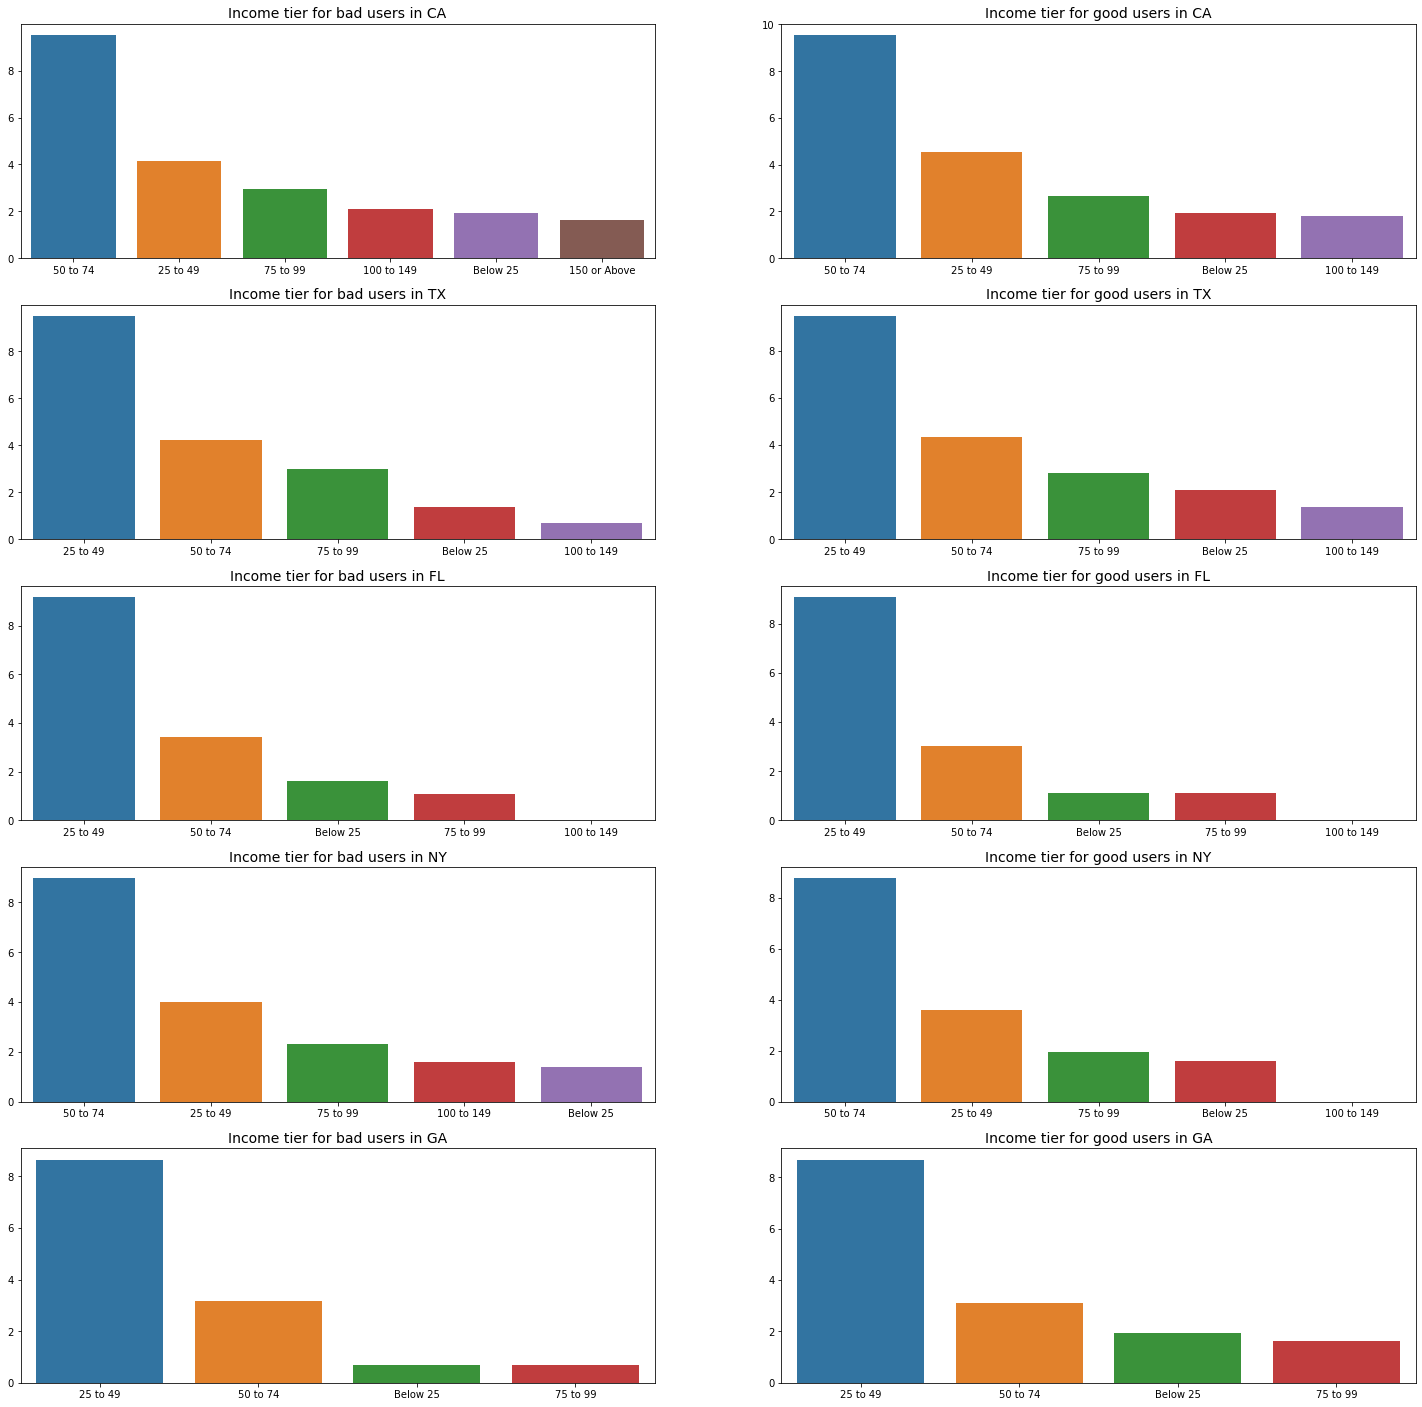

In [ ]:
f,ax=plt.subplots(nrows=5,ncols=2,figsize=(25,25))

for i,reg in enumerate(region):
   bad_reg=bad_users[bad_users.loc[:,'shipping_region']==reg].groupby('income_tier')['income_tier'].count().sort_values(ascending=False)
   good_reg=good_users[good_users.loc[:,'shipping_region']==reg].groupby('income_tier')['income_tier'].count().sort_values(ascending=False)
   sns.barplot(x=list(bad_reg.index),y=np.log(bad_reg.values),ax=ax[i,0])
   sns.barplot(x=list(good_reg.index),y=np.log(good_reg.values),ax=ax[i,1])
   ax[i,0].set_title('Income tier for bad users in {}'.format(reg),fontsize=14)
   ax[i,1].set_title('Income tier for good users in {}'.format(reg),fontsize=14)
   #print(bad_income_reg)

Most users in CA and NY belong to 50 to 74 income tier whereas in TX,FL and GA most users belong to the 25 to 49 income tier

Text(0.5, 1.0, 'Top 10 shipping cities for bad and good users')

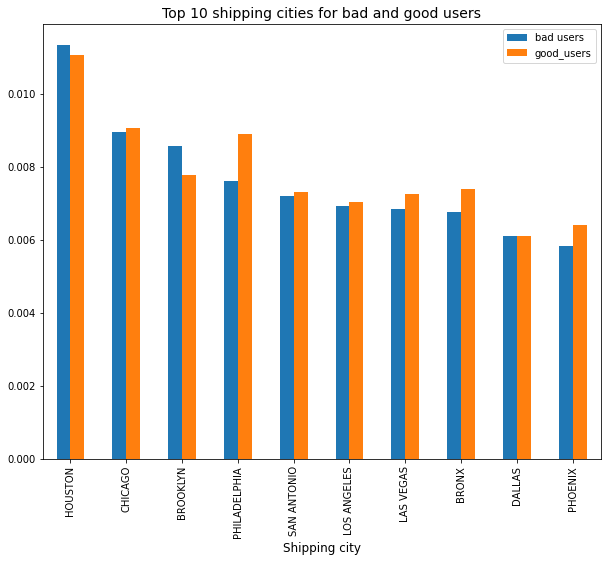

In [ ]:
bad=bad_users['shipping_city'].value_counts().head(10)/len(bad_users)
good=good_users['shipping_city'].value_counts().head(10)/len(good_users)
df=pd.concat([bad,good],axis=1).reset_index()
df.plot.bar(x='index',figsize=(10,8))
plt.legend(['bad users','good_users'])
plt.xlabel('Shipping city',fontsize=12)
plt.title('Top 10 shipping cities for bad and good users', fontsize=14)

In [ ]:
bad_users['target']=0                               #encoding good users and bad users with 0,1
good_users['target']=1

In [ ]:
users=pd.concat([bad_users,good_users],ignore_index=True)               #combining data for bad and good users

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264268 entries, 0 to 264267
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   subscription_hash             264268 non-null  object 
 1   channel                       264268 non-null  object 
 2   first_month_price             264268 non-null  float64
 3   email_domain                  264268 non-null  object 
 4   first_payment_type            172634 non-null  object 
 5   subscription_platform         264268 non-null  object 
 6   signup_platform               237650 non-null  object 
 7   fragrance_family              264268 non-null  object 
 8   scent_profile_title           21088 non-null   object 
 9   shipping_region               264268 non-null  object 
 10  shipping_city                 264268 non-null  object 
 11  is_upgraded_in_first_2_days   264268 non-null  bool   
 12  is_upcharged_in_first_2_days  264268 non-nul

In [ ]:
users['subscription_platform'].value_counts()

web        264184
iOS            44
Android        40
Name: subscription_platform, dtype: int64

most of the data is concentrated in 'web' in subscription_platform. Other categories are highly insignificant. 

In [ ]:
#dropping unuseful columns 
users=users.drop(['email_domain','signup_platform','subscription_platform','subscription_lifetime','scent_profile_title','shipping_city'],axis=1)

In [ ]:
users['minutes_from_registration'].value_counts()/len(users)

2          0.229256
3          0.203203
4          0.125475
5          0.075946
1          0.068226
             ...   
1222642    0.000004
868367     0.000004
280622     0.000004
294967     0.000004
2945       0.000004
Name: minutes_from_registration, Length: 21208, dtype: float64

In [ ]:
#binning minutes from registration
users['minutes_bucket']=pd.qcut(users['minutes_from_registration'],5,labels=['less than 2','2 to 3','3 to 4','4 to 8','8 above'])
users['minutes_bucket'].value_counts()/len(users)

less than 2    0.298269
2 to 3         0.203203
8 above        0.193247
4 to 8         0.179806
3 to 4         0.125475
Name: minutes_bucket, dtype: float64

In [ ]:
users=users[users.loc[:,'income_tier']!='Undefined']
users['income_tier'].where(users['income_tier'].isin(['25 to 49',
 '50 to 74',
 'Below 25']),'75 or above',inplace=True)
users['income_tier'].where(users['income_tier'].isin(['50 to 74','75 or above']),'below 49',inplace=True)
users['income_tier'].value_counts()/len(users)

below 49       0.564101
50 to 74       0.372404
75 or above    0.063494
Name: income_tier, dtype: float64

In [ ]:
users.groupby(['first_month_price','income_tier'])['income_tier'].count()/len(users)

first_month_price  income_tier
3.00               50 to 74       0.265675
                   75 or above    0.045586
                   below 49       0.409701
11.21              50 to 74       0.106729
                   75 or above    0.017909
                   below 49       0.154400
Name: income_tier, dtype: float64

There is no clear relation in customer's income and the subscription they purchase. For example people in below 25 tier also purchase 11.21 dollar subscription and people in 150 or Above tier also purchase 3 dollar subsccription

In [ ]:
users['first_payment_type'].fillna('NaN',inplace=True) #fillna('Card',inplace=True)
users['first_payment_type'].value_counts()/len(users)

Card            0.495871
NaN             0.346942
PayPal          0.146320
Prepaid Card    0.010867
Name: first_payment_type, dtype: float64

The missing values have been filled with Nan because their is no way of knowing what method the customers used for paying.Also, after feature importance and building 3 different models it has been found that the target is highly dependent on this feature. Hence we will not take the risk of messing with this feature 

In [ ]:
users['age_tier'].where(users['age_tier'].isin(['Below 18', '25 to 34', '35 to 44', '18 to 24']),'45 or above',inplace=True)
users['age_tier'].value_counts()/len(users)

Below 18       0.958699
25 to 34       0.013931
35 to 44       0.013370
45 or above    0.009347
18 to 24       0.004653
Name: age_tier, dtype: float64

In [ ]:
users['first_month_price']=users['first_month_price'].astype(str)
users['is_upcharged_in_first_2_days']=users['is_upcharged_in_first_2_days']*1
users['is_upgraded_in_first_2_days']=users['is_upgraded_in_first_2_days']*1

In [ ]:
users.columns

Index(['subscription_hash', 'channel', 'first_month_price',
       'first_payment_type', 'fragrance_family', 'shipping_region',
       'is_upgraded_in_first_2_days', 'is_upcharged_in_first_2_days',
       'minutes_from_registration', 'age_tier', 'sex', 'income_tier', 'target',
       'minutes_bucket'],
      dtype='object')

In [ ]:
y=users.set_index('subscription_hash')['target']

OHE Encoding

In [ ]:
xcol=['channel', 'first_month_price','first_payment_type','is_upgraded_in_first_2_days',
       'is_upcharged_in_first_2_days','age_tier', 'sex', 'income_tier', 'shipping_region'
       'minutes_bucket','fragrance_family']


In [ ]:
data_ohe=users.drop(['minutes_from_registration','target'],axis=1).copy()
data_ohe.set_index('subscription_hash',inplace=True)
l=list(data_ohe['shipping_region'].value_counts().index[0:10])
l
data_ohe['shipping_region'].where(data_ohe['shipping_region'].isin(l),'Other',inplace=True)
data_ohe['shipping_region'].value_counts()/len(users)

Other    0.458567
CA       0.105827
TX       0.101041
FL       0.069379
NY       0.054470
GA       0.044031
OH       0.035969
NC       0.034726
PA       0.034570
IL       0.033205
MI       0.028215
Name: shipping_region, dtype: float64

In [ ]:
data_ohe=pd.get_dummies(data_ohe,drop_first=True)
#data_ohe=data_ohe.reset_index().drop('subscription_hash',axis=1)
data_ohe['is_upgraded_in_first_2_days']=data_ohe['is_upgraded_in_first_2_days']*1
data_ohe['is_upcharged_in_first_2_days']=data_ohe['is_upcharged_in_first_2_days']*1
data_ohe.head()

,is_upgraded_in_first_2_days,is_upcharged_in_first_2_days,channel_Channel_2,channel_Channel_3,first_month_price_3.0,first_payment_type_NaN,first_payment_type_PayPal,first_payment_type_Prepaid Card,fragrance_family_1,shipping_region_FL,shipping_region_GA,shipping_region_IL,shipping_region_MI,shipping_region_NC,shipping_region_NY,shipping_region_OH,shipping_region_Other,shipping_region_PA,shipping_region_TX,age_tier_25 to 34,age_tier_35 to 44,age_tier_45 or above,age_tier_Below 18,sex_male,income_tier_75 or above,income_tier_below 49,minutes_bucket_2 to 3,minutes_bucket_3 to 4,minutes_bucket_4 to 8,minutes_bucket_8 above
subscription_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6c6f36cd8eb42ef1d905578a6b0947f534d6132ae1c02517a04c2f141c197671,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
73831634ef6d3639546fbb58f7ea4288220d907600fc9b2e6a71cef6f1d570ba,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0
75c705c4e9d81bb6037d2383118983f1f8009b6ae203d46868e930f356bc87b4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
20bb89aa63a1bc2a2f0c6e435a1da9057e52b6eec113fbb4e5f55fec76ef87ef,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0
160647d08b5d29ad4039b58f0c8f6515c29cdc7aae517e431ff46da3ed645dda,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0


In [ ]:
data_ohe=data_ohe.astype('int64')

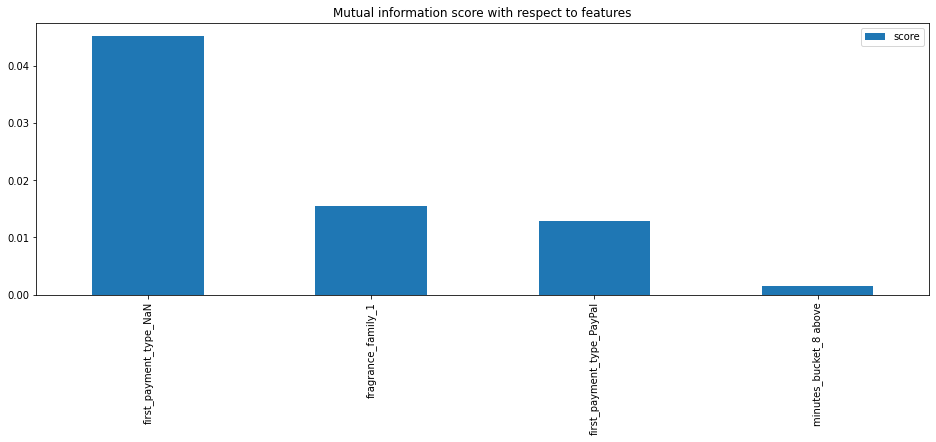

In [ ]:
#Mutual information score for feature selection

discrete_features = data_ohe.dtypes == int
#print(discrete_features)
mi = mutual_info_classif(data_ohe,y, discrete_features=discrete_features)
mi_scores = pd.DataFrame(mi, index=data_ohe.columns)
mi_scores.columns=['score']
mi_scores=mi_scores.sort_values(by='score', ascending=False)
mi_scores1=mi_scores.query('score>0.001')

mi_scores1.plot.bar(figsize = (16,5))
plt.title('Mutual information score with respect to features')
plt.show()

The missing values are more predictive than values!

I tried removing some of the columns which according to Mutual information score are not predictive but the metrics fell so no columns have been removed on the basis of this score

In [ ]:
features_train,features_test,target_train,target_test=train_test_split(data_ohe,y,test_size=0.20,random_state=4)

In [ ]:
features_train,features_val,target_train,target_val=train_test_split(features_train,target_train,test_size=0.25,random_state=4)

In [ ]:
print(features_train.shape,target_train.shape)

(158234, 30) (158234,)


In [ ]:
target_train.value_counts()/len(target_train)

0    0.503482
1    0.496518
Name: target, dtype: float64

In [ ]:
target_val.value_counts()/len(target_val)

0    0.50054
1    0.49946
Name: target, dtype: float64

In [ ]:
target_test.value_counts()/len(target_test)

0    0.50655
1    0.49345
Name: target, dtype: float64

Train,validation and test datasets have similar distribution of target

In [ ]:
#function for evaluating models
def evaluate(model,x,y,data):
  a=metrics.accuracy_score(y,model.predict(x))
  #p=metrics.precision_score(y,yhat)
  print("Accuracy",a)
  f1=metrics.f1_score(y,model.predict(x))
  print("F1 score",f1)
  auc_roc=metrics.roc_auc_score(y, model.predict_proba(x)[:,1])
  print("AUC ROC",auc_roc)
  metrics.plot_roc_curve(model,x,y)
  plt.title("ROC Curve for "+ data)
  disp = plot_confusion_matrix(model, x, y,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
  disp.ax_.set_title('Confusion Matrix')

  
  print(disp.confusion_matrix)

  #return a,f1,disp

Base Model

In [ ]:
features_train,features_test,target_train,target_test=train_test_split(data_ohe,y,test_size=0.25,random_state=4)

In [ ]:
logit=LogisticRegression(solver='saga',max_iter=200,penalty='elasticnet',class_weight='balanced',random_state=42)

In [ ]:
#using gaussian process minimize, a bayesian optimization technique for tuning l1_ratio
space=[Real(0,1,name='l1_ratio')]

@use_named_args(space)
def evaluate_model(**params):
	
	logit.set_params(**params)
	# calculate 5-fold cross validation
	result = cross_val_score(logit, features_train, target_train, cv=5, n_jobs=-1, scoring='roc_auc')
	# calculate the mean of the scores
	estimate = np.mean(result)
	return 1.0 - estimate

In [ ]:
res_gp = gp_minimize(evaluate_model, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)
print("Best parameters:")
print("l1_ratio:",res_gp.x[0])

Best score=0.2927
Best parameters:
l1_ratio: 0.47766511732135


Evaluation metrics for train set
Accuracy 0.6479046275651817
F1 score 0.5961143652496665
AUC ROC 0.7074805252568659
[[0.77211777 0.22788223]
 [0.47760769 0.52239231]]
Evaluation metrics for test set
Accuracy 0.6473737695469506
F1 score 0.5927586750512358
AUC ROC 0.7072918057913057
[[0.771872   0.228128  ]
 [0.48026417 0.51973583]]


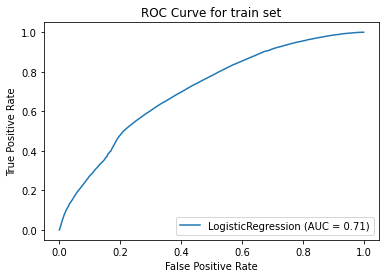

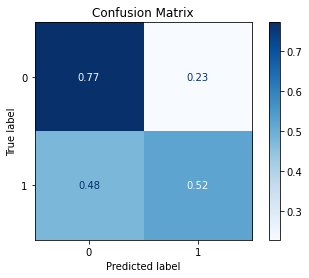

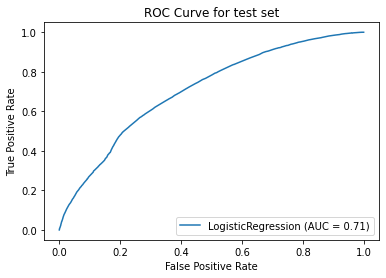

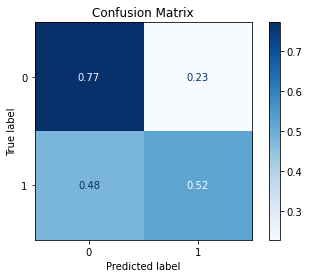

In [ ]:
logit=LogisticRegression(solver='saga',class_weight='balanced',max_iter=500,penalty='elasticnet',l1_ratio=0.477665,random_state=42)
logit.fit(features_train,target_train)

print("Evaluation metrics for train set")
evaluate(logit,features_train,target_train,'train set')

print("Evaluation metrics for test set")
evaluate(logit,features_test,target_test,'test set')


All the metrics have very similar values for train and test set which means our model is not overfitting. 

---

<font color='green'> 
**FM comments:**

I like your work - well done!

Several suggestions:

* Current form of confusion matrix does not show where is false negative and 
where is false positive values. I recomment to show it like that https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py 

* Probably, you can improve quality if change scoring function in *evaluate_model()* function.  

* Dataset is well balanced, therefore I suggest to show ROC AUC curve instead PR curve.


I believe that events data can improve results. Please ponder features you can construct from event logs. 

---



The base model ends here. Ahead we have other models which are still incomplete

In [ ]:
users.head()

,subscription_hash,channel,first_month_price,first_payment_type,fragrance_family,shipping_region,is_upgraded_in_first_2_days,is_upcharged_in_first_2_days,minutes_from_registration,age_tier,sex,income_tier,target,minutes_bucket
0,6c6f36cd8eb42ef1d905578a6b0947f534d6132ae1c025...,Channel_3,3.0,Card,0,FL,0,0,3,45 or above,female,below 49,0,2 to 3
1,73831634ef6d3639546fbb58f7ea4288220d907600fc9b...,Channel_1,11.21,Card,0,PA,0,1,3,Below 18,male,50 to 74,0,2 to 3
2,75c705c4e9d81bb6037d2383118983f1f8009b6ae203d4...,Channel_1,11.21,NaN,0,IN,0,1,2,Below 18,female,below 49,0,less than 2
3,20bb89aa63a1bc2a2f0c6e435a1da9057e52b6eec113fb...,Channel_3,3.0,Card,0,TX,0,0,3,Below 18,female,below 49,0,2 to 3
4,160647d08b5d29ad4039b58f0c8f6515c29cdc7aae517e...,Channel_1,11.21,NaN,0,TX,1,0,2,Below 18,female,below 49,0,less than 2


In [ ]:
users_cat=users.drop(['minutes_from_registration','target'],axis=1).set_index('subscription_hash')
x_train,x_test,y_train,y_test=train_test_split(users_cat,y,test_size=0.2,random_state=4)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.25,random_state=4)

In [ ]:
y_train.value_counts()

0    79668
1    78566
Name: target, dtype: int64

In [ ]:
from catboost import CatBoostClassifier
cat_features=['channel','first_month_price','first_payment_type','fragrance_family','shipping_region',
              'minutes_bucket','is_upgraded_in_first_2_days','is_upcharged_in_first_2_days','age_tier','sex','income_tier']
model = CatBoostClassifier(learning_rate=0.03,cat_features=cat_features,depth=6,class_weights=[1,1.014],
                           eval_metric='AUC',verbose=100,early_stopping_rounds=200)
# Fit model
model.fit(x_train, y_train,eval_set=(x_val,y_val))
# Get predicted classes
#preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
#preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
#preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

0:	test: 0.7120602	best: 0.7120602 (0)	total: 352ms	remaining: 5m 51s
100:	test: 0.7209166	best: 0.7209166 (100)	total: 19.5s	remaining: 2m 53s
200:	test: 0.7220413	best: 0.7220413 (200)	total: 39.7s	remaining: 2m 37s
300:	test: 0.7222345	best: 0.7222345 (300)	total: 58s	remaining: 2m 14s
400:	test: 0.7222973	best: 0.7222999 (399)	total: 1m 16s	remaining: 1m 54s
500:	test: 0.7223495	best: 0.7223537 (497)	total: 1m 36s	remaining: 1m 36s
600:	test: 0.7224210	best: 0.7224210 (600)	total: 1m 56s	remaining: 1m 17s
700:	test: 0.7224265	best: 0.7224265 (700)	total: 2m 16s	remaining: 58s
800:	test: 0.7224398	best: 0.7224506 (794)	total: 2m 35s	remaining: 38.5s
900:	test: 0.7224127	best: 0.7224506 (794)	total: 2m 54s	remaining: 19.2s
999:	test: 0.7224530	best: 0.7224573 (972)	total: 3m 13s	remaining: 0us

bestTest = 0.7224572973
bestIteration = 972

Shrink model to first 973 iterations.


Evaluation metrics for train set
Accuracy 0.6569763767584716
F1 score 0.6472843533524817
AUC ROC 0.7217867408182724
[[0.67972084 0.32027916]
 [0.36608711 0.63391289]]
Evaluation metrics for test set
Accuracy 0.6530476822447625
F1 score 0.6412749441329831
AUC ROC 0.7172885717585571
[[0.67699678 0.32300322]
 [0.37153725 0.62846275]]


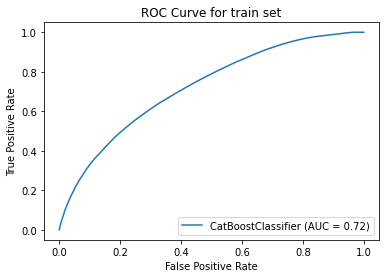

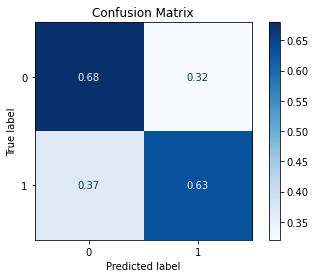

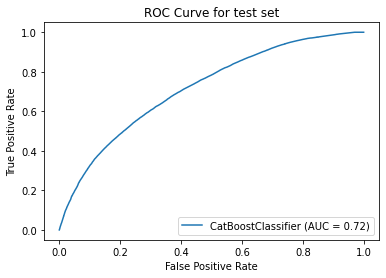

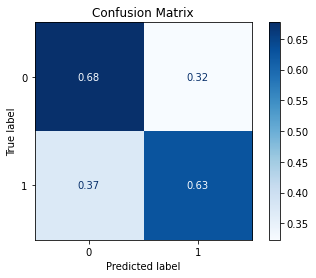

In [ ]:
print("Evaluation metrics for train set")
evaluate(model,x_train,y_train,'train set')

print("Evaluation metrics for test set")
evaluate(model,x_test,y_test,'test set')

In [ ]:
preds = model.predict(x_val)
print(confusion_matrix(y_val,preds)/(np.sum(confusion_matrix(y_val,preds),axis=1)).T)

[[0.68478467 0.31589736]
 [0.36684217 0.63236411]]


In [ ]:
disp = plot_confusion_matrix(catboost, x_test, y_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title('Confusion Matrix')

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
pd.Series(model.feature_importances_,index=users_cat.columns).sort_values(ascending=False)

first_payment_type              29.259379
fragrance_family                26.684997
channel                         20.567316
minutes_bucket                   5.995032
shipping_region                  4.644552
first_month_price                3.677304
sex                              3.064044
income_tier                      2.443370
age_tier                         2.102206
is_upgraded_in_first_2_days      1.397170
is_upcharged_in_first_2_days     0.164631
dtype: float64

In [ ]:
#users['shipping_region'].head()
# data_ohe=data_ohe.join(users[['shipping_region','fragrance_family']])
# data_ohe.head()

,is_upgraded_in_first_2_days,is_upcharged_in_first_2_days,channel_Channel_2,channel_Channel_3,first_month_price_3.0,first_payment_type_PayPal,first_payment_type_Prepaid Card,age_tier_25 to 34,age_tier_35 to 44,age_tier_45 or above,age_tier_Below 18,sex_male,income_tier_75 or above,income_tier_below 49,minutes_bucket_2 to 3,minutes_bucket_3 to 4,minutes_bucket_4 to 8,minutes_bucket_8 above,shipping_region,fragrance_family
subscription_hash,,,,,,,,,,,,,,,,,,,,
6c6f36cd8eb42ef1d905578a6b0947f534d6132ae1c02517a04c2f141c197671,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,FL,0
73831634ef6d3639546fbb58f7ea4288220d907600fc9b2e6a71cef6f1d570ba,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,PA,0
75c705c4e9d81bb6037d2383118983f1f8009b6ae203d46868e930f356bc87b4,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,IN,0
20bb89aa63a1bc2a2f0c6e435a1da9057e52b6eec113fbb4e5f55fec76ef87ef,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,TX,0
160647d08b5d29ad4039b58f0c8f6515c29cdc7aae517e431ff46da3ed645dda,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,TX,0


  shipping_region     train      test
0              AK  0.001839  0.002010
1              AL  0.010750  0.009802
2              AR  0.006876  0.006958
3              AZ  0.011824  0.011774
4              CA  0.054009  0.052289


Text(0.5, 1.0, 'Distribution of good and bad users shipping region wise')

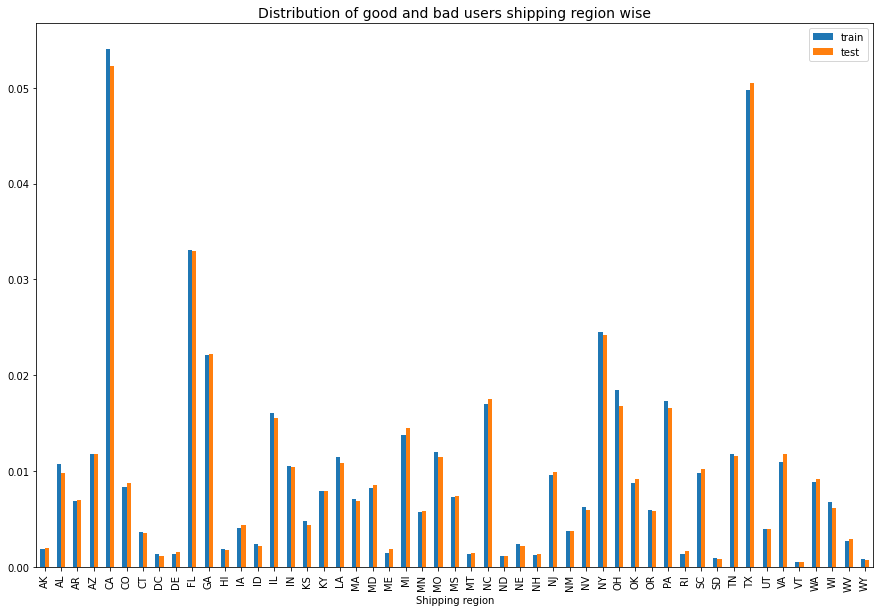

In [ ]:
train_shipping=features_train.join(target_train)
train_1_count=train_shipping[train_shipping['target']==1].groupby('shipping_region')['target'].count()/len(features_train)
train_1_count
test_shipping=features_test.join(target_test)
test_1_count=test_shipping[test_shipping['target']==1].groupby('shipping_region')['target'].count()/len(features_test)
df=pd.concat([train_1_count,test_1_count],axis=1)
df.columns=['train','test']
df=df.reset_index()
#print(df.head())
df.plot.bar(x='shipping_region',figsize=(15,10))
plt.legend(['train','test'])
plt.xlabel('Shipping region')
plt.title('Distribution of good users shipping region wise in train and test set', fontsize=14)

Text(0.5, 1.0, 'Distribution of bad users shipping region wise in train and test set')

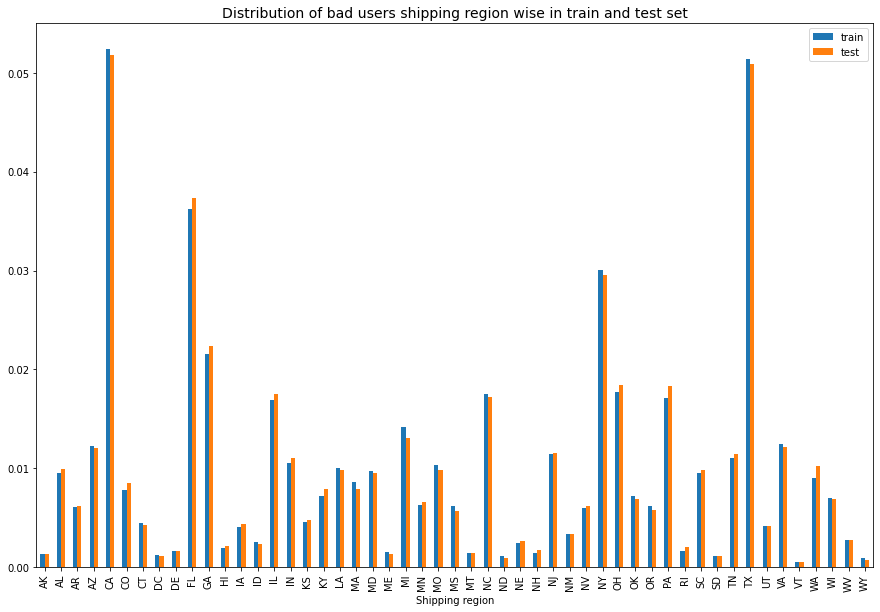

In [ ]:
train_shipping=features_train.join(target_train)
train_0_count=train_shipping[train_shipping['target']==0].groupby('shipping_region')['target'].count()/len(features_train)
train_0_count
test_shipping=features_test.join(target_test)
test_0_count=test_shipping[test_shipping['target']==0].groupby('shipping_region')['target'].count()/len(features_test)
df=pd.concat([train_0_count,test_0_count],axis=1)
df.columns=['train','test']
df=df.reset_index()
#print(df.head())
df.plot.bar(x='shipping_region',figsize=(15,10))
plt.legend(['train','test'])
plt.xlabel('Shipping region')
plt.title('Distribution of bad users shipping region wise in train and test set', fontsize=14)

In [ ]:
bad_log=pd.read_csv('/content/drive/MyDrive/scentbird data/ya_practicum_ltv_bad_users_events_dataset.csv')
good_log=pd.read_csv('/content/drive/MyDrive/scentbird data/ya_practicum_ltv_good_users_events_dataset.csv')

In [ ]:
bad_log.head()

In [ ]:
bad_log.info()

In [ ]:
bad_minutes=bad_log.groupby('subscription_hash').agg({'minutes_from_registration':['min','max','count'],'amount_of_events':['mean']})
bad_minutes.columns = ['_'.join(col) for col in bad_minutes.columns]

good_minutes=good_log.groupby('subscription_hash').agg({'minutes_from_registration':['min','max','count'],'amount_of_events':['mean']})
good_minutes.columns=['_'.join(col) for col in good_minutes.columns]

In [ ]:
bad_minutes['avg_time_btwn_visits']=((bad_minutes['minutes_from_registration_max']-bad_minutes['minutes_from_registration_min'])/
                                    bad_minutes['minutes_from_registration_count'])
bad_minutes

In [ ]:
good_minutes['avg_time_btwn_visits']=((good_minutes['minutes_from_registration_max']-good_minutes['minutes_from_registration_min'])/
                                    good_minutes['minutes_from_registration_count'])
good_minutes

In [ ]:
bad_log.pivot_table(index='browser_type',columns='event_name',values='subscription_hash',aggfunc='count')

Bad Users show no activity other than page views on browser and browser(mobile).

In [ ]:
good_log.pivot_table(index='browser_type',columns='event_name',values='subscription_hash',aggfunc='count')

How can a good user unsubscribe in the first  48 hours? This looks like an anomaly. We will drop this column for both good and bad users since a bad user will unsubscribe(maybe not in the first 48 hours), it does not matter what browser they use for it.

In [ ]:
bad_events=bad_log.pivot_table(index='subscription_hash',columns=['browser_type','event_name'],values='amount_of_events',aggfunc='mean')
bad_events.columns=['_'.join(col) for col in bad_events.columns]

good_events=good_log.pivot_table(index='subscription_hash',columns=['browser_type','event_name'],values='amount_of_events',aggfunc='mean')
good_events.columns=['_'.join(col) for col in good_events.columns]

bad_events.head()


In [ ]:
bad_events.columns

In [ ]:
bad_events=bad_events[['Browser_page_view', 'Browser (mobile)_page_view', 'Robot_AddToQueue','Robot_SubscriptionUpgrade', 'unknown_AddToQueue',
       'unknown_SubscriptionUpgrade','Robot_RemoveFromQueue']]

good_events=good_events[['Browser_page_view', 'Browser (mobile)_page_view', 'Robot_AddToQueue','Robot_SubscriptionUpgrade', 'unknown_AddToQueue',
       'unknown_SubscriptionUpgrade','Robot_RemoveFromQueue']]


In [ ]:
bad_events['target']=0
good_events['target']=1

In [ ]:
user_browser_family=bad_log['browser_family'].value_counts().reset_index().join(
    good_log['browser_family'].value_counts(),on='index',lsuffix='_bad',rsuffix='_good')
user_browser_family['total']=user_browser_family['browser_family_bad']+user_browser_family['browser_family_good']
user_browser_family['bad_rate']=user_browser_family['browser_family_bad']/user_browser_family['total']
user_browser_family['% population']=user_browser_family['total']/sum(user_browser_family['total'])
user_browser_family

,index,browser_family_bad,browser_family_good,total,bad_rate,% population
0,Chrome,320062,350116,670178,0.477578,0.374010
1,Safari,205024,139302,344326,0.595436,0.192160
2,Robot/Spider,168360,216492,384852,0.437467,0.214776
3,Unknown,135730,55036,190766,0.711500,0.106462
4,Apple WebKit,102932,87784,190716,0.539714,0.106434
5,Firefox,3300,2865,6165,0.535280,0.003441
6,Microsoft Edge,1951,1290,3241,0.601975,0.001809
7,Internet Explorer,512,321,833,0.614646,0.000465
8,Mozilla,163,503,666,0.244745,0.000372
9,Opera,95,35,130,0.730769,0.000073


In [ ]:
bad_features=bad_minutes.join(bad_events)
good_features=good_minutes.join(good_events)
user_features=pd.concat([bad_features,good_features])
user_features.shape,bad_features.shape+good_features.shape

Weight Of Evidence Encoding 

In [ ]:
users.head()

,subscription_hash,channel,first_month_price,first_payment_type,fragrance_family,shipping_region,is_upgraded_in_first_2_days,is_upcharged_in_first_2_days,minutes_from_registration,age_tier,sex,income_tier,target,minutes_bucket
0,6c6f36cd8eb42ef1d905578a6b0947f534d6132ae1c025...,Channel_3,3.0,Card,0,FL,0,0,3,45 or above,female,below 49,0,2 to 3
1,73831634ef6d3639546fbb58f7ea4288220d907600fc9b...,Channel_1,11.21,Card,0,PA,0,1,3,Below 18,male,50 to 74,0,2 to 3
2,75c705c4e9d81bb6037d2383118983f1f8009b6ae203d4...,Channel_1,11.21,NaN,0,IN,0,1,2,Below 18,female,below 49,0,less than 2
3,20bb89aa63a1bc2a2f0c6e435a1da9057e52b6eec113fb...,Channel_3,3.0,Card,0,TX,0,0,3,Below 18,female,below 49,0,2 to 3
4,160647d08b5d29ad4039b58f0c8f6515c29cdc7aae517e...,Channel_1,11.21,NaN,0,TX,1,0,2,Below 18,female,below 49,0,less than 2


In [ ]:
d = users[['shipping_region','target']].groupby("shipping_region",as_index=False).agg(["count", "sum"])
#print(d)
d.columns = ['N', 'Events']
d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
d['Non-Events'] = d['N'] - d['Events']
d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
d=d.reset_index().sort_values('WoE',ascending=False)
d

,shipping_region,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,AK,817,480,0.003666,337,0.002538,0.367733,4.147980e-04
25,MS,3509,1932,0.014755,1577,0.011876,0.217061,6.249254e-04
36,OK,4164,2276,0.017382,1888,0.014218,0.200931,6.357766e-04
24,MO,5767,3088,0.023584,2679,0.020175,0.156110,5.321314e-04
18,LA,5624,2977,0.022736,2647,0.019934,0.131519,3.685095e-04
2,AR,3439,1819,0.013892,1620,0.012200,0.129891,2.197996e-04
32,NM,1859,983,0.007507,876,0.006597,0.129273,1.176897e-04
1,AL,5385,2827,0.021591,2558,0.019264,0.114020,2.652801e-04
28,ND,601,312,0.002383,289,0.002176,0.090607,1.870187e-05
7,DC,637,330,0.002520,307,0.002312,0.086275,1.797303e-05


In [ ]:
user_features.fillna(0,inplace=True)

In [ ]:
df_woe=users.set_index('subscription_hash').drop(['minutes_from_registration','target'],axis=1)
df_woe.head()

,channel,first_month_price,first_payment_type,fragrance_family,shipping_region,is_upgraded_in_first_2_days,is_upcharged_in_first_2_days,age_tier,sex,income_tier,minutes_bucket
subscription_hash,,,,,,,,,,,
6c6f36cd8eb42ef1d905578a6b0947f534d6132ae1c02517a04c2f141c197671,Channel_3,3.0,Card,0,FL,0,0,45 or above,female,below 49,2 to 3
73831634ef6d3639546fbb58f7ea4288220d907600fc9b2e6a71cef6f1d570ba,Channel_1,11.21,Card,0,PA,0,1,Below 18,male,50 to 74,2 to 3
75c705c4e9d81bb6037d2383118983f1f8009b6ae203d46868e930f356bc87b4,Channel_1,11.21,NaN,0,IN,0,1,Below 18,female,below 49,less than 2
20bb89aa63a1bc2a2f0c6e435a1da9057e52b6eec113fbb4e5f55fec76ef87ef,Channel_3,3.0,Card,0,TX,0,0,Below 18,female,below 49,2 to 3
160647d08b5d29ad4039b58f0c8f6515c29cdc7aae517e431ff46da3ed645dda,Channel_1,11.21,NaN,0,TX,1,0,Below 18,female,below 49,less than 2


In [ ]:
df_woe.shape,users.shape

((263724, 11), (263724, 14))

In [ ]:
df_woe=df_woe.join(user_features,how='inner')
df_woe.shape,user_features.shape

((232653, 24), (233119, 13))

In [ ]:
#regions with similar WoE will be combined
#d=users[['shipping_region','target']]
r=[['NY','SD'],['CT','ND','MJ','MA'],['MN','FL'],['VA','RI','DE'],['WA','WY','TX','WI'],['HI','OR','IL','UT','ID','NH'],['PA','AZ'],
['MT','NC','IN','NE'],['OH','ME','IA'],['CA','MI','KS'],['WV','TN','GA','NV','VT','SC'],['AL','ND','DC','KY','CO'],
['MO','LA','AR','NM'],['OK','MS','AK']]
for i in r:
  #print(i)
    df_woe[df_woe['shipping_region'].isin(i)]['shipping_region']=i[0]
    #df_woe['shipping_region']=i[0]
  #print(df_woe['shipping_region'])
df_woe['shipping_region'].value_counts()

CA    24795
TX    23418
FL    16115
NY    12728
GA    10265
OH     8321
NC     8068
PA     8050
IL     7719
MI     6589
AZ     5634
VA     5460
TN     5275
MO     5055
LA     4976
IN     4907
NJ     4896
AL     4709
SC     4466
WA     4301
MD     4201
CO     3877
OK     3651
MA     3593
KY     3549
WI     3187
MS     3060
AR     3044
MN     2862
NV     2842
OR     2751
KS     2136
IA     1910
UT     1909
CT     1873
NM     1625
WV     1280
ID     1134
NE     1133
HI      913
AK      739
ME      726
RI      699
DE      695
MT      664
NH      636
DC      579
ND      533
SD      457
WY      402
VT      246
Name: shipping_region, dtype: int64

Can you please tell why this code is not working?

---
<font color='green'>FM comment </font>

I suspect it does not work because you create new dataframe (df_woe[df_woe['shipping_region'].isin(i)]) and change value of 'shipping_region' in this new dataset. It does not impact original dataframe.

First of all, never never never modify existing columns. If you want to create new feature, you had better add new column. For instance, call it *shipping_region_bucket_id*

How I would do it?
1. Create a dictionary {region_bucket_id: region_name}, i.e. {'NY': 1,'SD': 1,'CT': 2,'ND': 2,'MJ': 2,'MA': 2, ...}. Ponder a way to convert the list _r_ into thus dictionary - it's clever algorithmic exercise.
2. Apply the dictionary to the column *shipping_region* (https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html)  Write result into new column. Drop original columns if you wish.







In [ ]:
df_woe.head()

,channel,first_month_price,first_payment_type,fragrance_family,shipping_region,is_upgraded_in_first_2_days,is_upcharged_in_first_2_days,age_tier,sex,income_tier,minutes_bucket,minutes_from_registration_min,minutes_from_registration_max,minutes_from_registration_count,amount_of_events_mean,avg_time_btwn_visits,Browser_page_view,Browser (mobile)_page_view,Robot_AddToQueue,Robot_SubscriptionUpgrade,unknown_AddToQueue,unknown_SubscriptionUpgrade,Robot_RemoveFromQueue,target
subscription_hash,,,,,,,,,,,,,,,,,,,,,,,,
6c6f36cd8eb42ef1d905578a6b0947f534d6132ae1c02517a04c2f141c197671,Channel_3,3.0,Card,0,FL,0,0,45 or above,female,below 49,2 to 3,0,632,6,2.333333,105.333333,0.000000,1.4,0.000000,0.0,7.000000,0.0,0.00,0
73831634ef6d3639546fbb58f7ea4288220d907600fc9b2e6a71cef6f1d570ba,Channel_1,11.21,Card,0,PA,0,1,Below 18,male,50 to 74,2 to 3,0,980,17,1.529412,57.647059,0.000000,2.2,1.333333,1.0,0.000000,0.0,1.25,0
75c705c4e9d81bb6037d2383118983f1f8009b6ae203d46868e930f356bc87b4,Channel_1,11.21,NaN,0,IN,0,1,Below 18,female,below 49,less than 2,0,41,10,2.000000,4.100000,2.000000,1.0,2.166667,0.0,0.000000,0.0,0.00,0
20bb89aa63a1bc2a2f0c6e435a1da9057e52b6eec113fbb4e5f55fec76ef87ef,Channel_3,3.0,Card,0,TX,0,0,Below 18,female,below 49,2 to 3,3,444,18,2.000000,24.500000,0.000000,1.8,0.000000,0.0,2.428571,1.0,0.00,0
160647d08b5d29ad4039b58f0c8f6515c29cdc7aae517e431ff46da3ed645dda,Channel_1,11.21,NaN,0,TX,1,0,Below 18,female,below 49,less than 2,0,18,21,1.809524,0.857143,1.090909,0.0,3.285714,1.0,0.000000,0.0,1.00,0


In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            data=data.join(binned_x,lsuffix='_unbinned')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF,data

In [ ]:
newdf,woedf,data=iv_woe(df_woe,'target',bins=5,show_woe=True)   #users.drop(['subscription_hash','minutes_from_registration'],axis=1,'target')

Information value of channel is 0.001391
  Variable     Cutoff       N  ...  % of Non-Events       WoE        IV
0  channel  Channel_1   53138  ...         0.220753  0.066606  0.001013
1  channel  Channel_2   13655  ...         0.058234  0.015519  0.000014
2  channel  Channel_3  165860  ...         0.721012 -0.022604  0.000364

[3 rows x 9 columns]
Information value of first_month_price is 0.001269
            Variable Cutoff       N  ...  % of Non-Events       WoE        IV
0  first_month_price  11.21   66793  ...         0.278988  0.056155  0.000905
1  first_month_price    3.0  165860  ...         0.721012 -0.022604  0.000364

[2 rows x 9 columns]
Information value of first_payment_type is 0.424961
             Variable        Cutoff  ...       WoE        IV
0  first_payment_type          Card  ... -0.405905  0.077357
1  first_payment_type           NaN  ...  0.840617  0.249034
2  first_payment_type        PayPal  ... -0.839715  0.094160
3  first_payment_type  Prepaid Card  ...  0.68

In [ ]:
newdf.sort_values('IV',ascending=False).reset_index(drop=True)

,Variable,IV
0,first_payment_type,0.424961
1,fragrance_family,0.138704
2,Robot_AddToQueue,0.111003
3,unknown_AddToQueue,0.094567
4,minutes_from_registration_max,0.064202
5,avg_time_btwn_visits,0.054030
6,Browser_page_view,0.040695
7,minutes_from_registration_count,0.038556
8,minutes_bucket,0.022624
9,unknown_SubscriptionUpgrade,0.019037


In [ ]:
#these columns have very insignificant information value hence these will be dropped
l=['age_tier','is_upcharged_in_first_2_days','channel','first_month_price','is_upgraded_in_first_2_days','Robot_RemoveFromQueue']

In [ ]:
woedf.reset_index(inplace=True)
woedf

,index,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,0,channel,Channel_1,53138,27611,0.235957,25527,0.220753,0.066606,0.001013
1,1,channel,Channel_2,13655,6921,0.059145,6734,0.058234,0.015519,0.000014
2,2,channel,Channel_3,165860,82485,0.704898,83375,0.721012,-0.022604,0.000364
3,0,first_month_price,11.21,66793,34532,0.295102,32261,0.278988,0.056155,0.000905
4,1,first_month_price,3.0,165860,82485,0.704898,83375,0.721012,-0.022604,0.000364
...,...,...,...,...,...,...,...,...,...,...
115,0,unknown_AddToQueue,"(-0.001, 1.0]",194563,104369,0.891913,90194,0.779982,0.134098,0.015010
116,1,unknown_AddToQueue,"(1.0, 124.0]",38090,12648,0.108087,25442,0.220018,-0.710774,0.079558
117,0,unknown_SubscriptionUpgrade,0,227838,115697,0.988720,112141,0.969776,0.019346,0.000366
118,1,unknown_SubscriptionUpgrade,1,4815,1320,0.011280,3495,0.030224,-0.985574,0.018670


In [ ]:
data.head()

,channel,first_month_price,first_payment_type,fragrance_family,shipping_region,is_upgraded_in_first_2_days,is_upcharged_in_first_2_days,age_tier,sex,income_tier,minutes_bucket,minutes_from_registration_min_unbinned,minutes_from_registration_max_unbinned,minutes_from_registration_count_unbinned,amount_of_events_mean_unbinned,avg_time_btwn_visits_unbinned,Browser_page_view_unbinned,Browser (mobile)_page_view_unbinned,Robot_AddToQueue_unbinned,Robot_SubscriptionUpgrade,unknown_AddToQueue_unbinned,unknown_SubscriptionUpgrade,Robot_RemoveFromQueue_unbinned,target,minutes_from_registration_min,minutes_from_registration_max,minutes_from_registration_count,amount_of_events_mean,avg_time_btwn_visits,Browser_page_view,Browser (mobile)_page_view,Robot_AddToQueue,unknown_AddToQueue,Robot_RemoveFromQueue
subscription_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6c6f36cd8eb42ef1d905578a6b0947f534d6132ae1c02517a04c2f141c197671,Channel_3,3.0,Card,0,FL,0,0,45 or above,female,below 49,2 to 3,0,632,6,2.333333,105.333333,0.000000,1.4,0.000000,0.0,7.000000,0.0,0.00,0,"(-0.001, 1.0]","(455.0, 2879.0]","(4.0, 6.0]","(2.125, 3.25]","(35.488, 1437.5]","(-0.001, 1.25]","(1.0, 1.667]","(-0.001, 1.0]","(1.0, 124.0]","(-0.001, 36.0]"
73831634ef6d3639546fbb58f7ea4288220d907600fc9b2e6a71cef6f1d570ba,Channel_1,11.21,Card,0,PA,0,1,Below 18,male,50 to 74,2 to 3,0,980,17,1.529412,57.647059,0.000000,2.2,1.333333,1.0,0.000000,0.0,1.25,0,"(-0.001, 1.0]","(455.0, 2879.0]","(11.0, 307.0]","(1.25, 1.667]","(35.488, 1437.5]","(-0.001, 1.25]","(1.667, 2.286]","(1.0, 2.25]","(-0.001, 1.0]","(-0.001, 36.0]"
75c705c4e9d81bb6037d2383118983f1f8009b6ae203d46868e930f356bc87b4,Channel_1,11.21,NaN,0,IN,0,1,Below 18,female,below 49,less than 2,0,41,10,2.000000,4.100000,2.000000,1.0,2.166667,0.0,0.000000,0.0,0.00,0,"(-0.001, 1.0]","(24.0, 455.0]","(6.0, 11.0]","(1.667, 2.125]","(2.571, 35.488]","(1.25, 109.25]","(-0.001, 1.0]","(1.0, 2.25]","(-0.001, 1.0]","(-0.001, 36.0]"
20bb89aa63a1bc2a2f0c6e435a1da9057e52b6eec113fbb4e5f55fec76ef87ef,Channel_3,3.0,Card,0,TX,0,0,Below 18,female,below 49,2 to 3,3,444,18,2.000000,24.500000,0.000000,1.8,0.000000,0.0,2.428571,1.0,0.00,0,"(1.0, 2878.0]","(24.0, 455.0]","(11.0, 307.0]","(1.667, 2.125]","(2.571, 35.488]","(-0.001, 1.25]","(1.667, 2.286]","(-0.001, 1.0]","(1.0, 124.0]","(-0.001, 36.0]"
160647d08b5d29ad4039b58f0c8f6515c29cdc7aae517e431ff46da3ed645dda,Channel_1,11.21,NaN,0,TX,1,0,Below 18,female,below 49,less than 2,0,18,21,1.809524,0.857143,1.090909,0.0,3.285714,1.0,0.000000,0.0,1.00,0,"(-0.001, 1.0]","(8.0, 24.0]","(11.0, 307.0]","(1.667, 2.125]","(0.667, 1.25]","(-0.001, 1.25]","(-0.001, 1.0]","(2.25, 133.0]","(-0.001, 1.0]","(-0.001, 36.0]"


In [ ]:
data.columns

Index(['channel', 'first_month_price', 'first_payment_type',
       'fragrance_family', 'shipping_region', 'is_upgraded_in_first_2_days',
       'is_upcharged_in_first_2_days', 'age_tier', 'sex', 'income_tier',
       'minutes_bucket', 'minutes_from_registration_min_unbinned',
       'minutes_from_registration_max_unbinned',
       'minutes_from_registration_count_unbinned',
       'amount_of_events_mean_unbinned', 'avg_time_btwn_visits_unbinned',
       'Browser_page_view_unbinned', 'Browser (mobile)_page_view_unbinned',
       'Robot_AddToQueue_unbinned', 'Robot_SubscriptionUpgrade',
       'unknown_AddToQueue_unbinned', 'unknown_SubscriptionUpgrade',
       'Robot_RemoveFromQueue_unbinned', 'target',
       'minutes_from_registration_min', 'minutes_from_registration_max',
       'minutes_from_registration_count', 'amount_of_events_mean',
       'avg_time_btwn_visits', 'Browser_page_view',
       'Browser (mobile)_page_view', 'Robot_AddToQueue', 'unknown_AddToQueue',
       'Robot_Re

In [ ]:
df_woe=data.drop(['minutes_from_registration_min_unbinned',
       'minutes_from_registration_max_unbinned',
       'minutes_from_registration_count_unbinned',
       'amount_of_events_mean_unbinned', 'avg_time_btwn_visits_unbinned',
       'Browser_page_view_unbinned', 'Browser (mobile)_page_view_unbinned',
       'Robot_AddToQueue_unbinned','unknown_AddToQueue_unbinned', 'Robot_RemoveFromQueue_unbinned']+l,axis=1)

In [ ]:
# df_woe=users.set_index('subscription_hash').drop(['minutes_from_registration','is_upgraded_in_first_2_days','channel','first_month_price'],axis=1)
df_woe.shape

(232653, 18)

In [ ]:
for col in df_woe.columns:
  df_woe=df_woe.join(woedf[woedf['Variable']==col][['Cutoff','WoE']].set_index('Cutoff'),on=col,rsuffix='_{}'.format(col))

In [ ]:
df_woe.columns

Index(['first_payment_type', 'fragrance_family', 'shipping_region', 'sex',
       'income_tier', 'minutes_bucket', 'Robot_SubscriptionUpgrade',
       'unknown_SubscriptionUpgrade', 'target',
       'minutes_from_registration_min', 'minutes_from_registration_max',
       'minutes_from_registration_count', 'amount_of_events_mean',
       'avg_time_btwn_visits', 'Browser_page_view',
       'Browser (mobile)_page_view', 'Robot_AddToQueue', 'unknown_AddToQueue',
       'WoE', 'WoE_fragrance_family', 'WoE_shipping_region', 'WoE_sex',
       'WoE_income_tier', 'WoE_minutes_bucket',
       'WoE_Robot_SubscriptionUpgrade', 'WoE_unknown_SubscriptionUpgrade',
       'WoE_target', 'WoE_minutes_from_registration_min',
       'WoE_minutes_from_registration_max',
       'WoE_minutes_from_registration_count', 'WoE_amount_of_events_mean',
       'WoE_avg_time_btwn_visits', 'WoE_Browser_page_view',
       'WoE_Browser (mobile)_page_view', 'WoE_Robot_AddToQueue',
       'WoE_unknown_AddToQueue'],
      

In [ ]:
df_woe=df_woe[['WoE', 'WoE_fragrance_family', 'WoE_shipping_region', 'WoE_sex',
       'WoE_income_tier', 'WoE_minutes_bucket',
       'WoE_Robot_SubscriptionUpgrade', 'WoE_unknown_SubscriptionUpgrade',
       'WoE_minutes_from_registration_min',
       'WoE_minutes_from_registration_max',
       'WoE_minutes_from_registration_count', 'WoE_amount_of_events_mean',
       'WoE_avg_time_btwn_visits', 'WoE_Browser_page_view',
       'WoE_Browser (mobile)_page_view', 'WoE_Robot_AddToQueue',
       'WoE_unknown_AddToQueue','target']]

In [ ]:
df_woe.head()

,WoE,WoE_fragrance_family,WoE_shipping_region,WoE_sex,WoE_income_tier,WoE_minutes_bucket,WoE_Robot_SubscriptionUpgrade,WoE_unknown_SubscriptionUpgrade,WoE_minutes_from_registration_min,WoE_minutes_from_registration_max,WoE_minutes_from_registration_count,WoE_amount_of_events_mean,WoE_avg_time_btwn_visits,WoE_Browser_page_view,WoE_Browser (mobile)_page_view,WoE_Robot_AddToQueue,WoE_unknown_AddToQueue,target
subscription_hash,,,,,,,,,,,,,,,,,,
6c6f36cd8eb42ef1d905578a6b0947f534d6132ae1c02517a04c2f141c197671,-0.405905,-0.106821,-0.084756,-0.038495,0.035469,-0.093300,-0.027570,0.019346,0.033523,-0.288718,-0.097130,0.002378,-0.302438,0.100036,-0.104389,-0.223062,-0.710774,0
73831634ef6d3639546fbb58f7ea4288220d907600fc9b2e6a71cef6f1d570ba,-0.405905,-0.106821,-0.006406,0.133836,-0.026559,-0.093300,0.479102,0.019346,0.033523,-0.288718,-0.133854,-0.091741,-0.302438,0.100036,-0.140440,0.434450,0.134098,0
75c705c4e9d81bb6037d2383118983f1f8009b6ae203d46868e930f356bc87b4,0.840617,-0.106821,0.001578,-0.038495,0.035469,-0.141946,-0.027570,0.019346,0.033523,-0.241046,-0.245841,-0.052160,-0.243831,-0.408185,0.147451,0.434450,0.134098,0
20bb89aa63a1bc2a2f0c6e435a1da9057e52b6eec113fbb4e5f55fec76ef87ef,-0.405905,-0.106821,-0.019388,-0.038495,0.035469,-0.093300,-0.027570,-0.985574,-0.152058,-0.241046,-0.133854,-0.052160,-0.243831,0.100036,-0.140440,-0.223062,-0.710774,0
160647d08b5d29ad4039b58f0c8f6515c29cdc7aae517e431ff46da3ed645dda,0.840617,-0.106821,-0.019388,-0.038495,0.035469,-0.141946,0.479102,0.019346,0.033523,-0.069843,-0.133854,-0.052160,0.222648,0.100036,0.147451,0.535730,0.134098,0


In [ ]:
df_woe.isna().sum()/len(df_woe)

WoE                                    0.0
WoE_fragrance_family                   0.0
WoE_shipping_region                    0.0
WoE_sex                                0.0
WoE_income_tier                        0.0
WoE_minutes_bucket                     0.0
WoE_Robot_SubscriptionUpgrade          0.0
WoE_unknown_SubscriptionUpgrade        0.0
WoE_minutes_from_registration_min      0.0
WoE_minutes_from_registration_max      0.0
WoE_minutes_from_registration_count    0.0
WoE_amount_of_events_mean              0.0
WoE_avg_time_btwn_visits               0.0
WoE_Browser_page_view                  0.0
WoE_Browser (mobile)_page_view         0.0
WoE_Robot_AddToQueue                   0.0
WoE_unknown_AddToQueue                 0.0
target                                 0.0
dtype: float64

In [ ]:
df_woe.describe()

,WoE,WoE_fragrance_family,WoE_shipping_region,WoE_sex,WoE_income_tier,WoE_minutes_bucket,WoE_Robot_SubscriptionUpgrade,WoE_unknown_SubscriptionUpgrade,WoE_minutes_from_registration_min,WoE_minutes_from_registration_max,WoE_minutes_from_registration_count,WoE_amount_of_events_mean,WoE_avg_time_btwn_visits,WoE_Browser_page_view,WoE_Browser (mobile)_page_view,WoE_Robot_AddToQueue,WoE_unknown_AddToQueue,target
count,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000,232653.000000
mean,0.009631,0.013969,0.000019,0.000056,-0.000012,0.000294,0.000570,-0.001452,-0.000035,0.000458,0.000181,0.000026,-0.000065,-0.000921,0.000088,0.002940,-0.004225,0.502968
std,0.668106,0.396159,0.092604,0.071815,0.050651,0.150765,0.117061,0.143065,0.071426,0.254293,0.196763,0.072302,0.233095,0.202772,0.124003,0.335991,0.312621,0.499992
min,-0.839715,-0.106821,-0.209449,-0.038495,-0.158363,-0.141946,-0.027570,-0.985574,-0.152058,-0.288718,-0.245841,-0.091741,-0.302438,-0.408185,-0.140440,-0.223062,-0.710774,0.000000
25%,-0.405905,-0.106821,-0.049072,-0.038495,-0.026559,-0.141946,-0.027570,0.019346,0.033523,-0.241046,-0.133854,-0.052160,-0.243831,0.100036,-0.104389,-0.223062,0.134098,0.000000
50%,-0.405905,-0.106821,0.006201,-0.038495,0.035469,-0.093300,-0.027570,0.019346,0.033523,-0.069843,-0.097130,0.002378,0.061114,0.100036,-0.057506,-0.223062,0.134098,1.000000
75%,0.840617,-0.106821,0.052894,-0.038495,0.035469,0.096240,-0.027570,0.019346,0.033523,0.330935,0.209530,0.029609,0.222648,0.100036,0.147451,0.434450,0.134098,1.000000
max,0.840617,1.313264,0.357634,0.133836,0.035469,0.281775,2.386023,0.019346,0.033523,0.330935,0.245321,0.115663,0.256651,0.100036,0.147451,0.535730,0.134098,1.000000


In [ ]:
y=df_woe['target']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_woe.drop('target',axis=1), y, test_size=0.3, random_state=23)

In [ ]:
y_train.value_counts()/len(y_train)

1    0.503503
0    0.496497
Name: target, dtype: float64

In [ ]:
y_test.value_counts()/len(y_test)

1    0.501719
0    0.498281
Name: target, dtype: float64

In [ ]:
sgd=SGDClassifier(loss='log',random_state=4,penalty='elasticnet')

In [ ]:
#using gaussian process minimize, a bayesian optimization technique for tuning l1_ratio
space=[Real(10**-5, 10**0, "log-uniform", name='alpha'),Real(0,1,name='l1_ratio')]

@use_named_args(space)
def evaluate_model(**params):
	
	sgd.set_params(**params)
	# calculate 5-fold cross validation
	result = cross_val_score(sgd, x_train, y_train, cv=5, n_jobs=-1, scoring='roc_auc')
	# calculate the mean of the scores
	estimate = np.mean(result)
	return 1.0 - estimate

In [ ]:
res_gp = gp_minimize(evaluate_model, space, n_calls=50, random_state=0)



In [ ]:
print("Best score=%.4f" % res_gp.fun)
print("Best parameters:")
print("alpha:",res_gp.x[0])
print("l1_ratio:",res_gp.x[1])

Best score=0.2761
Best parameters:
alpha: 0.00016384078810752578
l1_ratio: 0.0


In [ ]:
sgd=SGDClassifier(loss='log',random_state=4,penalty='l2',alpha=0.00016)
sgd.fit(x_train,y_train)

SGDClassifier(alpha=0.00016, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=4, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Evaluation metrics for train set
Accuracy 0.6650128640463719
F1 score 0.6602056641732014
AUC ROC 0.7240149492577422
[[0.68395211 0.31604789]
 [0.35366285 0.64633715]]
Evaluation metrics for test set
Accuracy 0.6617284658146598
F1 score 0.6550766983199414
AUC ROC 0.7197293092295663
[[0.68336305 0.31663695]
 [0.35975784 0.64024216]]


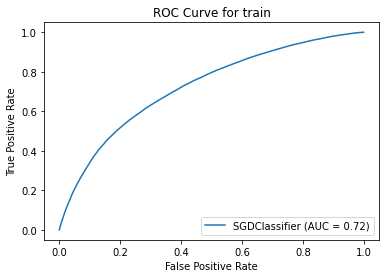

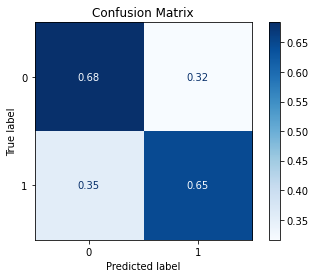

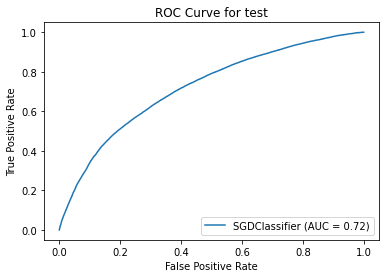

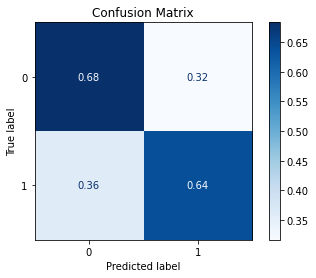

In [ ]:
print("Evaluation metrics for train set")
evaluate(sgd,x_train,y_train,'train')
print("Evaluation metrics for test set")
evaluate(sgd,x_test,y_test,'test')
#plt.title("Precision Recall curve for test set")

In [ ]:
print(pd.DataFrame(np.transpose(sgd.coef_),index=x_train.columns).sort_values(0,ascending=False))

                                            0
WoE_Browser_page_view                1.108646
WoE_minutes_bucket                   1.082368
WoE_shipping_region                  0.955069
WoE                                  0.841718
WoE_sex                              0.822980
WoE_minutes_from_registration_count  0.764112
WoE_Browser (mobile)_page_view       0.616639
WoE_minutes_from_registration_max    0.564582
WoE_Robot_AddToQueue                 0.553038
WoE_fragrance_family                 0.446930
WoE_Robot_SubscriptionUpgrade        0.391641
WoE_avg_time_btwn_visits             0.364205
WoE_minutes_from_registration_min    0.213242
WoE_unknown_AddToQueue               0.193399
WoE_unknown_SubscriptionUpgrade      0.126634
WoE_income_tier                      0.103640
WoE_amount_of_events_mean           -0.656754


In [ ]:
df_woe.columns

Index(['WoE', 'WoE_fragrance_family', 'WoE_shipping_region', 'WoE_sex',
       'WoE_income_tier', 'WoE_minutes_bucket',
       'WoE_Robot_SubscriptionUpgrade', 'WoE_unknown_SubscriptionUpgrade',
       'WoE_minutes_from_registration_min',
       'WoE_minutes_from_registration_max',
       'WoE_minutes_from_registration_count', 'WoE_amount_of_events_mean',
       'WoE_avg_time_btwn_visits', 'WoE_Browser_page_view',
       'WoE_Browser (mobile)_page_view', 'WoE_Robot_AddToQueue',
       'WoE_unknown_AddToQueue', 'target'],
      dtype='object')

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(df_woe.drop(['target'],axis=1),y,test_size=0.2,random_state=4)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.25,random_state=4)

In [ ]:
# cat_features=['channel','first_month_price','first_payment_type','fragrance_family','shipping_region',
#               'minutes_bucket','is_upgraded_in_first_2_days','is_upcharged_in_first_2_days','age_tier','sex','income_tier']
model = CatBoostClassifier(learning_rate=0.03,depth=6,class_weights=[1,1.014],
                           eval_metric='AUC',verbose=100,early_stopping_rounds=200)
# Fit model
model.fit(x_train, y_train,eval_set=(x_val,y_val))


0:	test: 0.7103862	best: 0.7103862 (0)	total: 65.2ms	remaining: 1m 5s
100:	test: 0.7275081	best: 0.7275081 (100)	total: 6.46s	remaining: 57.5s
200:	test: 0.7308512	best: 0.7308512 (200)	total: 12.9s	remaining: 51.2s
300:	test: 0.7322195	best: 0.7322195 (300)	total: 19.3s	remaining: 44.8s
400:	test: 0.7331231	best: 0.7331231 (400)	total: 25.7s	remaining: 38.3s
500:	test: 0.7336269	best: 0.7336269 (500)	total: 32.2s	remaining: 32s
600:	test: 0.7339328	best: 0.7339358 (599)	total: 38.6s	remaining: 25.6s
700:	test: 0.7340585	best: 0.7340630 (698)	total: 45s	remaining: 19.2s
800:	test: 0.7341063	best: 0.7341064 (715)	total: 51.5s	remaining: 12.8s
900:	test: 0.7341715	best: 0.7341721 (897)	total: 58s	remaining: 6.37s
999:	test: 0.7341283	best: 0.7341832 (925)	total: 1m 4s	remaining: 0us

bestTest = 0.7341831546
bestIteration = 925

Shrink model to first 926 iterations.


Evaluation metrics for train set
Accuracy 0.6809751345000752
F1 score 0.6788817502037049
AUC ROC 0.7471105271118919
[[0.69349058 0.30650942]
 [0.33132573 0.66867427]]
Evaluate metrics for test set
Accuracy 0.6713803700758634
F1 score 0.6693766351704901
AUC ROC 0.7328040951231198
[[0.67952919 0.32047081]
 [0.33671852 0.66328148]]


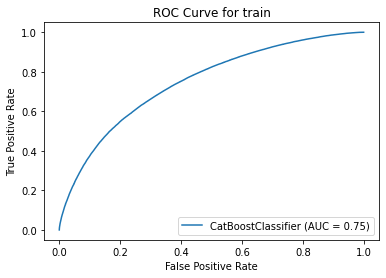

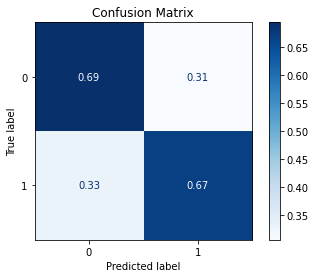

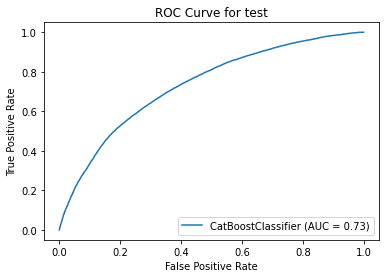

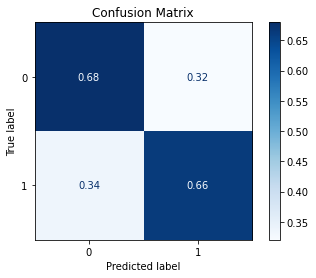

In [ ]:
print("Evaluation metrics for train set")
evaluate(model,x_train,y_train,'train')

print("Evaluate metrics for test set")
evaluate(model,x_test,y_test,'test')

CatBoost without WOE and without filling missing values

In [ ]:
users.head()

,subscription_hash,channel,first_month_price,first_payment_type,fragrance_family,shipping_region,is_upgraded_in_first_2_days,is_upcharged_in_first_2_days,minutes_from_registration,age_tier,sex,income_tier,target,minutes_bucket
0,6c6f36cd8eb42ef1d905578a6b0947f534d6132ae1c025...,Channel_3,3.0,Card,0,FL,0,0,3,45 or above,female,below 49,0,2 to 3
1,73831634ef6d3639546fbb58f7ea4288220d907600fc9b...,Channel_1,11.21,Card,0,PA,0,1,3,Below 18,male,50 to 74,0,2 to 3
2,75c705c4e9d81bb6037d2383118983f1f8009b6ae203d4...,Channel_1,11.21,NaN,0,IN,0,1,2,Below 18,female,below 49,0,less than 2
3,20bb89aa63a1bc2a2f0c6e435a1da9057e52b6eec113fb...,Channel_3,3.0,Card,0,TX,0,0,3,Below 18,female,below 49,0,2 to 3
4,160647d08b5d29ad4039b58f0c8f6515c29cdc7aae517e...,Channel_1,11.21,NaN,0,TX,1,0,2,Below 18,female,below 49,0,less than 2


In [ ]:
user_features.head()

,minutes_from_registration_min,minutes_from_registration_max,minutes_from_registration_count,amount_of_events_mean,avg_time_btwn_visits,Browser_page_view,Browser (mobile)_page_view,Robot_AddToQueue,Robot_SubscriptionUpgrade,unknown_AddToQueue,unknown_SubscriptionUpgrade,Robot_RemoveFromQueue,target
subscription_hash,,,,,,,,,,,,,
0000379144f24717a8d124d798008a0e672d93d4a95841fd2ea3d52f2a72353c,0,13,6,7.333333,2.166667,0.0,6.200000,13.0,0.0,0.0,0.0,0.0,0
000138229cb3f3f4d53b14b4e5412cd082139a2370f8d61fd0b503cf139813ce,2,2,1,1.000000,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0
00019fc35318081da6ad1ba08964bc86bae2bc325ce40317d2dcf368988eebea,0,1548,16,2.375000,96.750000,0.0,2.466667,0.0,0.0,1.0,0.0,0.0,0
00021d1beb2af3ad7557e188534c41954079fdbd692f328a5251835336ce4a6d,0,4,6,8.000000,0.666667,0.0,1.250000,0.0,0.0,21.5,0.0,0.0,0
00023bb62ee97828d0750f473e555a22040e3cec5a087ccb2ece2825b39450c7,0,2025,57,1.456140,35.526316,0.0,1.509804,0.0,0.0,1.0,0.0,0.0,0


In [ ]:
data=users.drop(['minutes_from_registration'],axis=1).join(user_features.drop('target',axis=1),on='subscription_hash',how='inner')
data.columns


Index(['subscription_hash', 'channel', 'first_month_price',
       'first_payment_type', 'fragrance_family', 'shipping_region',
       'is_upgraded_in_first_2_days', 'is_upcharged_in_first_2_days',
       'age_tier', 'sex', 'income_tier', 'target', 'minutes_bucket',
       'minutes_from_registration_min', 'minutes_from_registration_max',
       'minutes_from_registration_count', 'amount_of_events_mean',
       'avg_time_btwn_visits', 'Browser_page_view',
       'Browser (mobile)_page_view', 'Robot_AddToQueue',
       'Robot_SubscriptionUpgrade', 'unknown_AddToQueue',
       'unknown_SubscriptionUpgrade', 'Robot_RemoveFromQueue'],
      dtype='object')

In [ ]:
y=data['target']
x_train,x_test,y_train,y_test=train_test_split(data.drop(['subscription_hash','target'],axis=1),y,test_size=0.2,random_state=4)
#x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.25,random_state=4)

Best Model yet

In [ ]:
cat_features=['channel', 'first_month_price',
       'first_payment_type', 'fragrance_family', 'shipping_region',
       'is_upgraded_in_first_2_days', 'is_upcharged_in_first_2_days',
       'age_tier', 'sex', 'income_tier', 'minutes_bucket']
model = CatBoostClassifier(learning_rate=0.03,depth=6,cat_features=cat_features,class_weights=[1,1.014],
                           eval_metric='AUC',verbose=100,early_stopping_rounds=200, min_data_in_leaf=0.005)
# Fit model
model.fit(x_train, y_train,eval_set=(x_val,y_val))


0:	test: 0.7257678	best: 0.7257678 (0)	total: 480ms	remaining: 7m 59s
100:	test: 0.7517824	best: 0.7517824 (100)	total: 33s	remaining: 4m 53s
200:	test: 0.7572399	best: 0.7572399 (200)	total: 1m 5s	remaining: 4m 20s
300:	test: 0.7600820	best: 0.7600820 (300)	total: 1m 38s	remaining: 3m 48s
400:	test: 0.7622781	best: 0.7622781 (400)	total: 2m 12s	remaining: 3m 17s
500:	test: 0.7647697	best: 0.7647697 (500)	total: 2m 47s	remaining: 2m 46s
600:	test: 0.7665817	best: 0.7665817 (600)	total: 3m 21s	remaining: 2m 13s
700:	test: 0.7680490	best: 0.7680490 (700)	total: 3m 56s	remaining: 1m 40s
800:	test: 0.7693317	best: 0.7693317 (800)	total: 4m 31s	remaining: 1m 7s
900:	test: 0.7704352	best: 0.7704352 (900)	total: 5m 6s	remaining: 33.7s
999:	test: 0.7713244	best: 0.7713244 (999)	total: 5m 40s	remaining: 0us

bestTest = 0.7713243805
bestIteration = 999



Evaluation metrics for train set
Accuracy 0.6969998173241208
F1 score 0.7027351841992905
AUC ROC 0.7718195699938131
[[0.682244   0.317756  ]
 [0.28843937 0.71156063]]
Evaluate metrics for test set
Accuracy 0.6885302271603877
F1 score 0.6955699792047387
AUC ROC 0.7604445239820756
[[0.6674571  0.3325429 ]
 [0.29052577 0.70947423]]


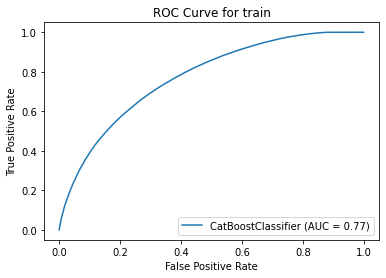

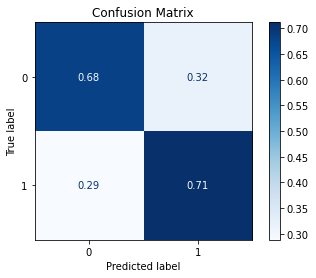

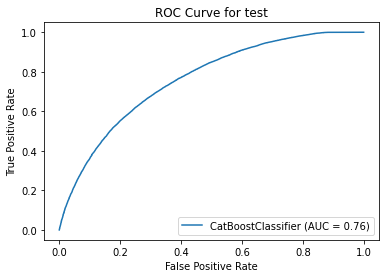

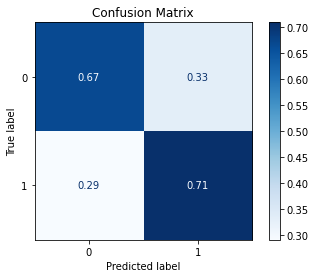

In [ ]:
print("Evaluation metrics for train set")
evaluate(model,x_train,y_train,'train')

print("Evaluate metrics for test set")
evaluate(model,x_test,y_test,'test')